In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import datetime
import collections

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
from __future__ import print_function, division

import numpy as np

import hosts
import targeting

from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import *
from astropy import table
from astropy.visualization import hist as ahist
from astropy.io import fits
from astropy import convolution

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (16, 10)

In [4]:
from urllib2 import urlopen
import bs4 # for parsing html in the HSLA

In [5]:
def add_coord_to_tab(tab, raname='RA', decname='Dec', unit=u.deg, coocolname='skycoord'):
    coo = SkyCoord(ra=tab[raname], dec=tab[decname], unit=unit, frame='icrs')
    tab[coocolname] = coo
    return coo

In [6]:
imagelist_kwargs={}
# this supresses actually showing the imagelists - comment it out to get the imagelists to pop up
imagelist_kwargs['url'] = None

# Load the SAGA datasets 

## First load the flag0/host lists

In [7]:
export_url_templ = 'https://docs.google.com/spreadsheets/d/{id}/export?format=csv&id={id}&gid={gid}'
base_id = '1b3k2eyFjHFDtmHce1xi6JKuj3ATOWYduTBFftx5oPp8'
flag0_gid = '448084634'
nsats_gid = '271797930'
all_gid = '0'

tab_all_hosts = table.Table.read(export_url_templ.format(id=base_id, gid=all_gid), format='csv')
# "flag0-except-for-SDSS-footprint"
tab_flag0notsdss = tab_all_hosts[(tab_all_hosts['flag'] & 16271)==0]
add_coord_to_tab(tab_flag0notsdss)  # because these are used directly later - the latter two are combined

tab_flag0 = table.Table.read(export_url_templ.format(id=base_id, gid=flag0_gid), format='csv')
tab_nsats0 = table.Table.read(export_url_templ.format(id=base_id, gid=nsats_gid), format='csv')

In [8]:
print(len(tab_flag0))
tab_flag0[:5].show_in_notebook()

74


idx,NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,u-r,sersic_n,stellar_mass,N_sats_all,N_sats_removed,N_sats_rem1and2,N_SDSS_sats,N_sats_total,u_abs_nsa,g_abs_nsa,r_abs_nsa,i_abs_nsa,z_abs_nsa
0,32,145.514,0.336452,27723,1912.35,30.0374,11.8626,11.603,11.4285,10.53,8.848,0.036,0,-23.5403,-20.5257,37.2791,8.62942,13.304,0.974112,1.63536,1.3137,16800000000,1,1,1,1,1,-18.89037514,-19.98466873,-20.52573967,-20.78533936,-20.95985794
1,13927,180.676,1.9768,38031,1961.14,29.5168,12.0011,11.5644,11.2205,10.98,8.743,0.027,0,-23.6073,-20.3492,62.2704,3.36159,11.815,0.98222,2.43461,3.12889,19800000000,0,0,0,0,0,-17.91459847,-19.50808334,-20.34920692,-20.7858963,-21.12985611
2,16235,139.416,52.993,26246,2274.04,36.2141,12.9972,12.5874,12.277,14.99,9.406,0.02,0,-23.3884,-19.7972,43.0944,13.055,12.621,0.972638,2.35828,1.49728,12000000000,8,3,3,3,3,-17.43894196,-19.0068531,-19.79722595,-20.2069931,-20.5173645
3,16559,154.888,58.2058,30176,2099.41,34.4951,12.3762,11.8854,11.586,11.85,9.469,0.031,0,-23.2198,-20.3126,49.2187,8.48479,11.148,0.98321,1.98864,1.75007,19100000000,4,2,3,3,3,-18.32392502,-19.55516624,-20.31256104,-20.80337524,-21.10277939
4,33446,123.241,36.2546,23028,2469.7,37.7379,12.3668,12.0137,11.739,11.77,9.407,0.032,0,-23.4769,-20.5171,31.306,14.5285,12.875,0.972509,2.04922,2.13367,21200000000,2,2,2,2,2,-18.46783257,-19.79914093,-20.51705551,-20.87019157,-21.14492035


In [9]:
print(len(tab_nsats0))
tab_nsats0[:5].show_in_notebook()

74


idx,NSAID,RA,Dec,N_sats_all,N_sats_removed,N_sats_rem1and2,N_SDSS_sats,N_sats_total
0,145729,224.594,-1.09102,1,1,1,1,1
1,150887,348.683,4.53406,0,0,0,0,0
2,140594,180.098,-1.10008,2,1,2,1,1
3,142722,194.863,14.1712,5,2,2,2,2
4,150578,346.236,12.3229,0,0,0,0,0


### Combine the two together 

In [11]:
tab_hosts = table.join(tab_flag0, tab_nsats0[[nm for nm in tab_nsats0.colnames if nm.startswith('N')]], 'NSAID')
add_coord_to_tab(tab_hosts)

print(len(tab_hosts))
tab_hosts[:5].show_in_notebook()

74


idx,NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,u-r,sersic_n,stellar_mass,N_sats_all_1,N_sats_removed_1,N_sats_rem1and2_1,N_SDSS_sats_1,N_sats_total_1,u_abs_nsa,g_abs_nsa,r_abs_nsa,i_abs_nsa,z_abs_nsa,N_sats_all_2,N_sats_removed_2,N_sats_rem1and2_2,N_SDSS_sats_2,N_sats_total_2,skycoord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
0,32,145.514,0.336452,27723,1912.35,30.0374,11.8626,11.603,11.4285,10.53,8.848,0.036,0,-23.5403,-20.5257,37.2791,8.62942,13.304,0.974112,1.63536,1.3137,16800000000,1,1,1,1,1,-18.89037514,-19.98466873,-20.52573967,-20.78533936,-20.95985794,1,1,1,1,1,"145.514,0.336452"
1,13927,180.676,1.9768,38031,1961.14,29.5168,12.0011,11.5644,11.2205,10.98,8.743,0.027,0,-23.6073,-20.3492,62.2704,3.36159,11.815,0.98222,2.43461,3.12889,19800000000,0,0,0,0,0,-17.91459847,-19.50808334,-20.34920692,-20.7858963,-21.12985611,0,0,0,0,0,"180.676,1.9768"
2,16235,139.416,52.993,26246,2274.04,36.2141,12.9972,12.5874,12.277,14.99,9.406,0.02,0,-23.3884,-19.7972,43.0944,13.055,12.621,0.972638,2.35828,1.49728,12000000000,8,3,3,3,3,-17.43894196,-19.0068531,-19.79722595,-20.2069931,-20.5173645,8,3,3,3,3,"139.416,52.993"
3,16559,154.888,58.2058,30176,2099.41,34.4951,12.3762,11.8854,11.586,11.85,9.469,0.031,0,-23.2198,-20.3126,49.2187,8.48479,11.148,0.98321,1.98864,1.75007,19100000000,4,2,3,3,3,-18.32392502,-19.55516624,-20.31256104,-20.80337524,-21.10277939,4,2,3,3,3,"154.888,58.2058"
4,33446,123.241,36.2546,23028,2469.7,37.7379,12.3668,12.0137,11.739,11.77,9.407,0.032,0,-23.4769,-20.5171,31.306,14.5285,12.875,0.972509,2.04922,2.13367,21200000000,2,2,2,2,2,-18.46783257,-19.79914093,-20.51705551,-20.87019157,-21.14492035,2,2,2,2,2,"123.241,36.2546"


In [12]:
# just in case lets save out a local copy
#fn = 'hosts_flag0_tab_{}.ecsv'.format(datetime.datetime.now().strftime('%F'))
#print('writing', fn)
#tab_hosts.write(fn, format='ascii.ecsv')

#or load with
#tab_hosts = table.Table.read(fn, format='ascii.ecsv')

## And also load the sats list 

In [12]:
tab_specs = table.Table.read('SAGADropbox/data/saga_spectra_clean.fits.gz')
add_coord_to_tab(tab_specs, raname='RA', decname='DEC')

tab_sats = tab_specs[(tab_specs['ZQUALITY']>=3)&(tab_specs['REMOVE']==-1)&(tab_specs['SATS']==1)]

print(len(tab_specs), len(tab_sats))
tab_sats[:5].show_in_notebook()

68105 168


idx,OBJID,RA,DEC,PHOTPTYPE,PHOT_SG,FLAGS,clean,SATURATED,BAD_COUNTS_ERROR,BINNED1,TOO_FEW_GOOD_DETECTIONS,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,survey,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_MR,HOST_MG,HOST_NSAID,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS,SPECOBJID,SPEC_REPEAT,SPEC_SN,SPEC_HA_EW,SPEC_HA_EWERR,skycoord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
0,1237648722289295527,145.320962664,0.771102651396,3,GALAXY,68988043776,1,0,0,268435456,0,18.7395,17.6063,17.1605,16.9516,16.7769,0.0283063,0.00646028,0.00594115,0.00720908,0.0171965,0.0273266,0.0062947,0.00570953,0.00689574,0.0178854,0.608006,0.447365,0.324466,0.246033,0.174441,18.2627,17.2831,16.9258,16.7912,16.6819,3.77931,4.4029,4.98527,5.1239,24.9092,0.217144,0.111835,0.141186,0.116695,8.51344,2.57427,0.425552,3.45923,0.0851165,4.06205,0.12706,4.24132,0.119345,5.17283,0.379126,0.670546,0.681586,0.688063,0.712973,0.707609,18.9483,0.0272871,17.6245,0.00638381,17.0989,0.00582051,16.8696,0.00705032,16.6378,0.0185209,20.0718,0.0352348,19.106,0.0140474,18.602,0.0193119,18.4885,0.0157263,18.4235,0.0277232,20.0572,0.0323801,18.96,0.00819829,18.549,0.00751242,18.3379,0.00918833,18.148,0.024217,0.251249,0.395446,0.344743,0.334241,0.323474,0.0608646,0.0327015,0.0777924,0.0654216,0.0742687,0.0610308,0.0632748,0.0512498,0.0413077,0.105914,0.71549,1.59726,14.1018,0.710982,1.90739,21.88,0.731562,2.04755,20.5199,0.758912,2.02837,20.178,0.737766,2.04899,30.4873,19.2578,0.010051,17.2503,0.00570953,2.23696,5.74052,17.1605,20.8019040859,20.9041968097,16.638,0.145,16.03,0.2,15.33,9999.0,sdss,0.00658949,6.01168e-06,0,0.017868,0.006357,-1.0,-1.0,-1.0,-1.0,145.513690377,0.336451585096,30.0373516083,1912.34655762,-23.5218249121,-21.2755714191,-20.7350530517,32,,28.5287841155,249.26771538,30,1,0.666416895163,-1.0,-1,NSA,sdss,4,,1.23764872229e+18,NSA,nan,26.0362949371,0.72926735878,"145.320962664,0.771102651396"
1,1237651735757259099,180.636494306,1.95802947978,3,GALAXY,281543964623104,0,0,0,268435456,281474976710656,26.9357,19.2637,18.6728,18.9803,26.7732,3.48973,0.0899796,0.0839212,0.173803,0.658678,3.48973,0.0899796,0.0839212,0.173803,0.658678,0.115032,0.0846394,0.0613876,0.0465483,0.0330033,26.8206,19.1791,18.6114,18.9337,26.7402,2.97098,2.97006,258.374,2.96948,2.97022,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,2.12566,3.65126,29.6753,2.31745,27.1824,8.31657,29.6695,2.53441,0.00358716,27.1103,0.05,0.623367,0.999923,0.952344,0.0501283,21.8828,0.386924,19.1192,0.0916567,17.2244,0.0721443,18.0551,0.166074,22.1379,0.697607,22.5648,0.410591,22.7915,0.17871

### Also figure out which are the saga hosts

In [13]:
saga_hosts = hosts.get_saga_hosts_from_google()
saga_hosts_nsaids = {host.nsaid: host for host in saga_hosts}

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [14]:
saga_names = []
for nsaid in tab_hosts['NSAID']:
    if nsaid in saga_hosts_nsaids:
        saga_names.append(saga_hosts_nsaids[nsaid].name)
    else:
        saga_names.append('')
tab_hosts['SAGA_name'] = saga_names

# Now collect Jason T's QSO datasets 

In [15]:
tab_qso = table.Table(table.Table.read('catalogs/dr7qso_galex.fits'), masked=True)
add_coord_to_tab(tab_qso, raname='RA', decname='DEC')

tab_qso19 = tab_qso[(0<tab_qso['FUV_MAG'])&(tab_qso['FUV_MAG']<19)]

print(len(tab_qso), len(tab_qso19))
tab_qso19[:5].show_in_notebook()

105811 2627


idx,SDSSNAME,RA,DEC,Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,A_U,LOGNHI,FIRSTMAG,FIRST_SN,FIRST_SEP,LG_RASS_RATE,RASS_SN,RASS_SEP,TWOMASSMAG_J,TWOMASSMAGERR_J,TWOMASSMAG_H,TWOMASSMAGERR_H,TWOMASSMAG_K,TWOMASSMAGERR_K,TWOMASS_SEP,M_I,DELTA_G_I,MORPHOLOGY,SCIENCEPRIMARY,MODE,UNIFORM,BESTPRIMTARGET,TS_B_QSO,TS_B_HIZ,TS_B_FIRST,TS_B_ROSAT,TS_B_SERENDIP,TS_B_STAR,TS_B_GAL,RUN_BEST,MJD_BEST,MJD_SPEC,PLATE,FIBERID,RERUN_BEST,CAMCOL_BEST,FIELD_BEST,OBJ_BEST,TARGPRIMTARGET,TS_T_QSO,TS_T_HIZ,TS_T_FIRST,TS_T_ROSAT,TS_T_SERENDIP,TS_T_STAR,TS_T_GAL,T_PSFMAG_U,T_PSFMAGERR_U,T_PSFMAG_G,T_PSFMAGERR_G,T_PSFMAG_R,T_PSFMAGERR_R,T_PSFMAG_I,T_PSFMAGERR_I,T_PSFMAG_Z,T_PSFMAGERR_Z,BESTOBJID,SPECOBJID,OBJECT_NAME,GALEX_OBJID,GALEX_RA,GALEX_DEC,GALEX_SEP,GALEX_TYPE,GALEX_BAND,NUV_FLUX,NUV_FLUXERR,FUV_FLUX,FUV_FLUXERR,NUV_MAG,NUV_MAGERR,FUV_MAG,FUV_MAGERR,GALEX_NOBJ,skycoord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
0,000011.96+000225.3,0.0498390011489,0.0403649993241,0.4789,18.228,0.027,17.934,0.02,17.995,0.019,17.934,0.014,17.873,0.029,0.161,20.502,0.0,0.0,0.0,-1.66,2.157,2.04,16.651,0.136,15.82,0.149,14.821,0.111,0.209,-24.068,-0.146,0,1,1,0,134224898,1,0,0,1,0,0,0,3325,52522,51791,387,200,41,4,108,19,134224900,1,0,0,1,0,0,0,17.835,0.011,17.58,0.004,17.695,0.005,17.646,0.006,17.66,0.024,588015509269381139,109153257477111808,LBQS 2357-0014,6381013764764861047,0.0498250763621,0.0404867856438,0.441287278442,1,3,198.586,9.1663,134.936,12.7213,18.1527,0.0501274,18.5776,0.102384,2,"0.0498390011489,0.0403649993241"
1,000110.97-105247.4,0.295722007751,-10.8798570633,0.5282,17.999,0.022,17.674,0.026,17.646,0.016,17.484,0.024,17.512,0.028,0.183,20.439,0.0,0.0,0.0,-9.0,0.0,0.0,16.467,0.095,15.614,0.112,14.916,0.108,0.155,-24.764,0.017,0,1,1,0,1048578,1,0,0,0,1,0,0,1740,51814,52143,650,126,40,1,24,71,1048580,1,0,0,0,1,0,0,17.95,0.018,17.65,0.018,17.658,0.018,17.506,0.018,17.501,0.021,587727225153388615,183182687870124032,SDSS J000110.97-105247.4,2435007175675876212,0.295777766876,-10.8798445586,0.20219960592,0,3,226.309,2.69221,141.979,3.5783,18.0108,0.0129192,18.5223,0.0273704,2,"0.295722007751,-10.8798570633"
2,000410.80-104527.1,1.04502701759,-10.7575368881,0.2397,18.125,0.025,17.951,0.02,17.681,0.027,17.531,0.013,17.432,0.021,0.192,20.444,0.0,0.0,0.0,-1.352,3.3,7.26,16.097,0.087,15.181,0.098,14.368,0.072,0.091,-22.829,-0.221,0,1,1,0,7170,1,0,0,1,0,0,0,1729,51813,52143,650,18,40,2,90,17,7172,1,0,0,1,0,0,0,18.096,0.018,17.929,0.018,17.693,0.017,17.522,0.013,17.409,0.018,587727178449944593,183182687417139200,SDSS J000410.80-104527.1,6380415564941101376,1.04514692228,-10.7574263506,0.581539875822,1,3,101.836,6.96794,113.507,11.1903,18.8778,0.0743079,18.7653,0.107066,2,"1.04502701759,-10.7575368881"
3,000548.24-084808.4,1.45100700855,-8.80234718323,1.1906,17.968,0.034,17.874,0.035,17.623,0.019,17.636,0.022,17.715,0.027,0.172,20.487,0.0,0.0,0.0,-9.0,0.0,0.0,17.126,0.259,16.657,0.296,0.0,0.0,0.019,-26.577,-0.057,0,1,1,0,2,1,0,0,0,0,0,0,1740,51814,52141,651,328,40,6,32,7,4,1,0,0,0,0,0,0,17.92,0.014,17.892,0.014,17.663,0.007,17.629,0.018,17.705,0.025,587727227838267399,183464155104149504,SDSS J000548.24-084808.4,6380415545613749966,1.45083866643,-8.8023579513,0.600147137654,1,3,221.995,7.46231,98.0474,8.59181,18.0317,0.0365057,18.9243,0.0951652,2,"1.45100700855,-8.80234718323"
4,000557.23+002837.7,1.48849904537,0.477142989635,0.2596,18.587,0.024,18.566,0.024,18.41,0.023,18.369,0.027,17.857,0.049,0.282,20.479,0.0,0.0,0.0,-9.0,0.0,0.0,16.691,0.149,15.911,0.139,15.121,0.106,0.125,-22.215,-0.202,0,1,1,0,3,1,1,0,0,0,0,0,3325,52522,51793,388,385,41,5,118,37,4,1,0,0,0,0,0,0,18.517,0.018,18.493,0.008,18.303,0.011,18.173,0.014,17.795,0.023,588015509806907429,109434741819703296,LBQS 0003+0011,6381013763691121033,1.48841064477,0.477408398602,1.00707414717,1,3,98.6517,6.81361,123.574,11.0682,18.9123,0.0750071,18.6731,0.0972697,1,"1.48849904537,0.47714298963

In [16]:
with fits.open('https://archive.stsci.edu/missions/hlsp/uvqs/hlsp_uvqs_multi_multi_all_multi_v1_redshifts.fits', 
              cache=True) as f:
    uvqs_tab = table.Table.read(f)
add_coord_to_tab(uvqs_tab, raname='RA', decname='DEC')

# JT recommended this cut
uvqs_good_tab = uvqs_tab[uvqs_tab['Z_QUAL']>=3]

print(len(uvqs_good_tab))
uvqs_good_tab[:5].show_in_notebook()

1121


idx,DEC,FUV,NAME,NUV,OBJ,OBJ_IDX,OBJ_IDX2,OBSV,OBS_DATE,RA,SCI_FILE,SCND_FILE,SPEC_QUAL,THETA [20],W1,W2,Z,ZASS_FIL,Z_QUAL,Z_SIG,comment,dbx_path,instr,CAND,SPEC_FILE,FINDER,skycoord
,deg,,,,,,,,,deg,,,,,,,,,,,,,,,,,"deg,deg"
0,-20.0743611111,18.2729988098,UVQSJ000000.15-200427.7,17.9699993134,0,1,-1,LCO,Aug2014,0.000625,09aug2014/Science/sci-ccd0918.fits.gz,,3,4.39948940277 .. 0.0,13.5480003357,12.5389995575,0.290799587965,LCO_09aug2014_zassess.fits,4,0.000171106687048,,LCO/August2014,BCS,1,UVQSJ000000.15-200427.7_LCO.fits,UVQSJ000000.15-200427.7_DSS.pdf,"0.000625,-20.0743611111"
1,-39.2966388889,17.8244285583,UVQSJ000503.70-391747.9,17.2321929932,0,0,-1,LCO,Aug2014,1.26541666667,07aug2014/Science/sci-ccd0645.fits.gz,,3,8.0866317749 .. 0.0,12.2600002289,11.1239995956,0.652394294739,LCO_07aug2014_zassess.fits,3,0.000363261176972,,LCO/August2014,BCS,1,UVQSJ000503.70-391747.9_LCO.fits,UVQSJ000503.70-391747.9_DSS.pdf,"1.26541666667,-39.2966388889"
2,-26.1945833333,18.1590518951,UVQSJ000609.57-261140.5,17.5298900604,0,1,-1,LCO,Aug2014,1.539875,09aug2014/Science/sci-ccd0920.fits.gz,,3,5.21646022797 .. 0.0,13.3079996109,12.1239995956,0.648431241512,LCO_09aug2014_zassess.fits,3,0.000249826902291,,LCO/August2014,BCS,1,UVQSJ000609.57-261140.5_LCO.fits,UVQSJ000609.57-261140.5_DSS.pdf,"1.539875,-26.1945833333"
3,42.2796111111,18.0854568481,UVQSJ000717.69+421646.6,17.6127948761,0,0,0,Lick,Jan2015,1.82370833333,Jan_2015/Science/sci-b337.fits.gz,Jan_2015/Science/sci-r337.fits.gz,4,17.7751274109 .. 0.0,12.4420003891,11.5080003738,0.0,Lick_jan2015_zassess.fits,4,0.000228934150073,,Lick,Kast,1,UVQSJ000717.69+421646.6_Lick.fits,UVQSJ000717.69+421646.6_DSS.pdf,"1.82370833333,42.2796111111"
4,-63.8627222222,17.9553394318,UVQSJ000741.00-635145.8,17.4110488892,0,0,-1,LCO,Aug2014,1.92083333333,07aug2014/Science/sci-ccd0640.fits.gz,,3,4.41201686859 .. 0.0,12.6529998779,11.454000473,0.55930185318,LCO_07aug2014_zassess.fits,3,0.000405291531933,,LCO/August2014,BCS,1,UVQSJ000741.00-635145.8_LCO.fits,UVQSJ000741.00-635145.8_DSS.pdf,"1.92083333333,-63.8627222222"


# Load pre-existing COS spectra from HSLA

In [17]:
hsla_url = 'https://archive.stsci.edu/missions/hst/spectral_legacy/samples/QSOALS_sample.html'
hsla_qso_tab = table.Table.read(hsla_url, format='html')

In [18]:
# saved a local copy so that it can be reused later if need be
#hsla_qso_tab.write('catalogs/hsla_qsos.ecsv', format='ascii.ecsv')

# reuse with this
#hsla_qso_tab = table.Table.read('catalogs/hsla_qsos.ecsv', format='ascii.ecsv')

In [19]:
add_coord_to_tab(hsla_qso_tab, 'RA', 'DEC')
print(len(hsla_qso_tab))

hsla_qso_tab[:5].show_in_notebook()

690


idx,Number,Target Name,RA,DEC,Nexp,Target Description,AltName,AltClass,Redshift,MAST,Median S/N,FUV M,FUV L,Download,skycoord
,,,,,,,,,,,,,,,"deg,deg"
0,1,2XMM-J141348.3+440014,213.451,44.0039,28,GALAXY;QUASAR,PG 1411+442,G,0.089,MAST,27.7527,--,. . .,ALL,"213.451,44.0039"
1,2,J102847.00+391800.4,157.196,39.3001,5,GALAXY;QSO,2MASSi J1028470+391800,QSO,0.472,MAST,9.59722,. . .,--,ALL,"157.196,39.3001"
2,3,RXSJ00508+3536,12.7114,35.6119,32,GALAXY;SEYFERT,2MASX J00505076+3536430,G,0.058,MAST,17.2908,--,. . .,ALL,"12.7114,35.6119"
3,4,TON0133,192.751,30.4283,6,GALAXY;QSO,TON 0133,QSO,0.652,MAST,10.0172,--,. . .,. . .,"192.751,30.4283"
4,5,QSO-231145-141752,347.939,-14.2978,4,GALAXY;LYMAN ALPHA C,. . .,. . .,. .,MAST,2.09867,. . .,--,ALL,"347.939,-14.2978"


In [20]:
# now populate the QSO tables with matches in the HSLA

def add_hsla_match(tab, hsla_sep_threshold=10*u.arcsec):
    idx, d2d, _ = tab['skycoord'].match_to_catalog_sky(hsla_qso_tab['skycoord'])
    #hsla_match_idx = -np.ones(len(idx))
    #hsla_match_idx[d2d<hsla_sep_threshold] = idx[d2d<hsla_sep_threshold]
    #tab['hsla_match_idx'] =  hsla_match_idx
    tab['hsla_match_idx'] = np.ma.masked_where(d2d>hsla_sep_threshold, idx)
    
tab_qso = table.Table(tab_qso, masked=True)
tab_qso19 = table.Table(tab_qso19, masked=True)
add_hsla_match(tab_qso)
add_hsla_match(tab_qso19)

# X-match hosts 

In [21]:
def get_host_matches(hosttab, qsotab, rvir=300*u.kpc, hsla_sep_threshold=10*u.arcsec):
    tabs = []
    for row in hosttab:
        sc = row['skycoord']
        rvirsep = (rvir/(row['distance']*u.Mpc)).decompose()*u.radian
        seps = sc.separation(qsotab['skycoord'])
        
        subtab = qsotab[seps < rvirsep]
        subtab['qso_to_host'] = seps[seps < rvirsep]
        subtab['qso_to_host_phys'] = seps[seps < rvirsep].to(u.radian).value*(row['distance']*u.Mpc).to(u.kpc)

        tabs.append(subtab)
    return tabs

In [22]:
host_matches = get_host_matches(tab_hosts, tab_qso)
host_matches19 = get_host_matches(tab_hosts, tab_qso19)

n19 = [np.sum((0<match['FUV_MAG'])&(match['FUV_MAG']<19)) for match in host_matches]
n185 = [np.sum((0<match['FUV_MAG'])&(match['FUV_MAG']<18.5)) for match in host_matches]
n18 = [np.sum((0<match['FUV_MAG'])&(match['FUV_MAG']<18)) for match in host_matches]

tab_hosts['n_qso_fuv_lt_19'] = n19
tab_hosts['n_qso_fuv_lt_18.5'] = n185
tab_hosts['n_qso_fuv_lt_18'] = n18

In [23]:
host_matches_uvqs = get_host_matches(tab_hosts, uvqs_good_tab)

n19_uvqs = [np.sum((0<match['FUV'])&(match['FUV']<19)) for match in host_matches_uvqs]
n185_uvqs = [np.sum((0<match['FUV'])&(match['FUV']<18.5)) for match in host_matches_uvqs]
n18_uvqs = [np.sum((0<match['FUV'])&(match['FUV']<18)) for match in host_matches_uvqs]

tab_hosts['n_uvqs_fuv_lt_19'] = n19_uvqs
tab_hosts['n_uvqs_fuv_lt_18.5'] = n185_uvqs
tab_hosts['n_uvqs_fuv_lt_18'] = n18_uvqs

In [24]:
host_matches_flag0notsdss_uvqs = get_host_matches(tab_flag0notsdss, uvqs_good_tab)

n19_flag0notsdss_uvqs = [np.sum((0<match['FUV'])&(match['FUV']<19)) for match in host_matches_flag0notsdss_uvqs]
n185_flag0notsdss_uvqs = [np.sum((0<match['FUV'])&(match['FUV']<18.5)) for match in host_matches_flag0notsdss_uvqs]
n18_flag0notsdss_uvqs = [np.sum((0<match['FUV'])&(match['FUV']<18)) for match in host_matches_flag0notsdss_uvqs]

tab_flag0notsdss['n_uvqs_fuv_lt_19'] = n19_flag0notsdss_uvqs
tab_flag0notsdss['n_uvqs_fuv_lt_18.5'] = n185_flag0notsdss_uvqs
tab_flag0notsdss['n_uvqs_fuv_lt_18'] = n18_flag0notsdss_uvqs

## Some summaries of numbers for hosts 

In [25]:
tab_hosts.show_in_notebook(75)

idx,NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,u-r,sersic_n,stellar_mass,N_sats_all_1,N_sats_removed_1,N_sats_rem1and2_1,N_SDSS_sats_1,N_sats_total_1,u_abs_nsa,g_abs_nsa,r_abs_nsa,i_abs_nsa,z_abs_nsa,N_sats_all_2,N_sats_removed_2,N_sats_rem1and2_2,N_SDSS_sats_2,N_sats_total_2,skycoord,SAGA_name,n_qso_fuv_lt_19,n_qso_fuv_lt_18.5,n_qso_fuv_lt_18,n_uvqs_fuv_lt_19,n_uvqs_fuv_lt_18.5,n_uvqs_fuv_lt_18
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,
0,32,145.514,0.336452,27723,1912.35,30.0374,11.8626,11.603,11.4285,10.53,8.848,0.036,0,-23.5403,-20.5257,37.2791,8.62942,13.304,0.974112,1.63536,1.3137,16800000000,1,1,1,1,1,-18.89037514,-19.98466873,-20.52573967,-20.78533936,-20.95985794,1,1,1,1,1,"145.514,0.336452",,0,0,0,0,0,0
1,13927,180.676,1.9768,38031,1961.14,29.5168,12.0011,11.5644,11.2205,10.98,8.743,0.027,0,-23.6073,-20.3492,62.2704,3.36159,11.815,0.98222,2.43461,3.12889,19800000000,0,0,0,0,0,-17.91459847,-19.50808334,-20.34920692,-20.7858963,-21.12985611,0,0,0,0,0,"180.676,1.9768",Sopranos,1,1,1,0,0,0
2,16235,139.416,52.993,26246,2274.04,36.2141,12.9972,12.5874,12.277,14.99,9.406,0.02,0,-23.3884,-19.7972,43.0944,13.055,12.621,0.972638,2.35828,1.49728,12000000000,8,3,3,3,3,-17.43894196,-19.0068531,-19.79722595,-20.2069931,-20.5173645,8,3,3,3,3,"139.416,52.993",,0,0,0,0,0,0
3,16559,154.888,58.2058,30176,2099.41,34.4951,12.3762,11.8854,11.586,11.85,9.469,0.031,0,-23.2198,-20.3126,49.2187,8.48479,11.148,0.98321,1.98864,1.75007,19100000000,4,2,3,3,3,-18.32392502,-19.55516624,-20.31256104,-20.80337524,-21.10277939,4,2,3,3,3,"154.888,58.2058",,0,0,0,0,0,0
4,33446,123.241,36.2546,23028,2469.7,37.7379,12.3668,12.0137,11.739,11.77,9.407,0.032,0,-23.4769,-20.5171,31.306,14.5285,12.875,0.972509,2.04922,2.13367,21200000000,2,2,2,2,2,-18.46783257,-19.79914093,-20.51705551,-20.87019157,-21.14492035,2,2,2,2,2,"123.241,36.2546",StarTrek,0,0,0,0,0,0
5,52773,193.841,58.3442,44025,2490.64,38.4771,12.406,12.05,11.79,11.39,9.047,0.023,0,-23.879,-20.52,58.7766,12.3121,11.077,0.986942,2.07612,1.75581,20300000000,0,0,0,0,0,-18.44392395,-19.80266571,-20.52004051,-20.87601089,-21.13601494,0,0,0,0,0,"193.841,58.3442",,0,0,0,0,0,0
6,61945,354.131,0.297265,71883,2556.76,34.7674,12.0858,11.7031,11.4059,11.65,9.3,0.03,0,-23.4059,-20.6201,-57.1915,9.4085,12.75,0.988686,2.44616,6.0,24700000000,9,2,7,2,2,-18.1739006,-19.82550621,-20.62006378,-21.0027504,-21.29995155,9,2,7,2,2,"354.131,0.297265",AnaK,0,0,0,0,0,0
7,63326,248.606,21.5409,58523,2936.5,41.3763,12.9283,12.5722,12.2773,--,9.588,0.027,0,-23.4958,-20.1555,39.299,15.3853,--,0.971828,1.96522,2.23754,13900000000,0,0,0,0,0,-18.19023514,-19.44906235,-20.15545464,-20.5115509,-20.80647469,0,0,0,0,0,"248.606,21.5409",,0,0,0,0,0,0
8,69028,210.708,49.1726,50031,2012.51,31.7148,11.9989,11.5817,11.2854,11.28,8.789,0.027,0,-23.7173,-20.5074,64.0123,8.35729,10.968,0.98862,2.4304,1.78293,23000000000,4,3,3,3,3,-18.07701683,-19.6860733,-20.50741959,-20.92463493,-21.22086716,4,3,3,3,3,"210.708,49.1726",,0,0,0,0,0,0


In [26]:
print('FUV<19 (JTQSO, UVQS)')
print(np.sum(tab_hosts['n_qso_fuv_lt_19']), np.sum(tab_hosts['n_uvqs_fuv_lt_19']),'\n')

print('FUV<18.5 (JTQSO, UVQS)')
print(np.sum(tab_hosts['n_qso_fuv_lt_18.5']), np.sum(tab_hosts['n_uvqs_fuv_lt_18.5']),'\n')

print('FUV<18 (JTQSO, UVQS)')
print(np.sum(tab_hosts['n_qso_fuv_lt_18']), np.sum(tab_hosts['n_uvqs_fuv_lt_18']))

FUV<19 (JTQSO, UVQS)
23 1 

FUV<18.5 (JTQSO, UVQS)
11 1 

FUV<18 (JTQSO, UVQS)
6 1


In [27]:
tab_hosts[tab_hosts['n_qso_fuv_lt_19']>0].show_in_notebook()

idx,NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,u-r,sersic_n,stellar_mass,N_sats_all_1,N_sats_removed_1,N_sats_rem1and2_1,N_SDSS_sats_1,N_sats_total_1,u_abs_nsa,g_abs_nsa,r_abs_nsa,i_abs_nsa,z_abs_nsa,N_sats_all_2,N_sats_removed_2,N_sats_rem1and2_2,N_SDSS_sats_2,N_sats_total_2,skycoord,SAGA_name,n_qso_fuv_lt_19,n_qso_fuv_lt_18.5,n_qso_fuv_lt_18,n_uvqs_fuv_lt_19,n_uvqs_fuv_lt_18.5,n_uvqs_fuv_lt_18
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,
0,13927,180.676,1.9768,38031,1961.14,29.5168,12.0011,11.5644,11.2205,10.98,8.743,0.027,0,-23.6073,-20.3492,62.2704,3.36159,11.815,0.98222,2.43461,3.12889,19800000000,0,0,0,0,0,-17.91459847,-19.50808334,-20.34920692,-20.7858963,-21.12985611,0,0,0,0,0,"180.676,1.9768",Sopranos,1,1,1,0,0,0
1,85746,149.588,32.3699,28805,1451.33,25.1343,12.5439,12.2105,11.9101,11.27,8.899,0.016,0,-23.1023,-19.4575,52.3205,7.2153,--,0.978734,1.95676,0.932093,7680000000,1,1,1,0,1,-17.50070763,-18.75543785,-19.45746422,-19.79086494,-20.09119606,1,1,1,0,1,"149.588,32.3699",MobyDick,3,2,2,0,0,0
2,94217,209.233,29.1644,49604,2373.26,34.6222,12.0542,11.6782,11.428,11.83,9.237,0.034,0,-23.4598,-20.6425,75.4319,7.6542,13.59,0.990282,2.39188,5.16674,25900000000,1,1,1,1,1,-18.25065231,-19.87423325,-20.64253044,-21.01856422,-21.26874733,1,1,1,1,1,"209.233,29.1644",,1,0,0,0,0,0
3,135440,130.666,14.2856,24464,2060.0,32.7765,12.0386,11.635,11.3438,10.61,8.649,0.017,0,-23.9288,-20.5392,30.9871,11.5907,11.77,0.971145,2.64515,3.66924,24500000000,1,1,1,1,1,-17.89406776,-19.71510506,-20.539217,-20.94282913,-21.23396683,1,1,1,1,1,"130.666,14.2856",,1,1,0,0,0,0
4,135879,141.077,34.5135,26649,1687.0,27.6714,11.588,11.2183,10.9256,--,8.032,0.016,0,-24.1782,-20.6222,45.4015,9.01869,13.189,0.981817,2.58665,4.30874,26100000000,5,4,4,4,4,-18.035532,-19.84670448,-20.62217712,-20.99190712,-21.2845459,5,4,4,4,4,"141.077,34.5135",,1,1,1,0,0,0
5,138201,162.818,27.9751,32533,1414.0,24.2202,11.2539,10.856,10.5627,9.87,7.972,0.014,0,-23.9489,-20.667,63.4186,5.00724,9.909,0.977563,2.63738,3.98633,27500000000,6,5,5,5,5,-18.02964783,-19.87112427,-20.66703224,-21.06489563,-21.35819626,6,5,5,5,5,"162.818,27.9751",,2,1,0,0,0,0
6,140301,177.289,27.022,36914,1798.0,28.2771,11.7576,11.4055,11.1582,10.41,8.693,0.02,0,-23.5642,-20.4996,76.1447,4.186,9.944,0.987064,2.34973,3.00455,22700000000,3,2,3,2,2,-18.14984894,-19.75426102,-20.49957848,-20.85170364,-21.09892845,3,2,3,2,2,"177.289,27.022",,1,1,1,0,0,0
7,140594,180.098,-1.10008,37845,1465.0,23.2487,11.1116,10.7406,10.4707,9.35,7.321,0.015,0,-24.511,-20.7204,59.2146,2.29212,12.669,0.985217,2.05631,1.7545,20600000000,2,1,2,1,1,-18.6640892,-20.00681305,-20.72039795,-21.09139061,-21.36133385,2,1,2,1,1,"180.098,-1.10008",Alice,1,1,1,0,0,0
8,142722,194.863,14.1712,44600,1988.0,30.027,11.4723,11.0534,10.7367,9.93,7.907,0.016,0,-24.4806,-20.9153,76.9088,3.38499,10.768,0.987676,2.70741,2.18747,35000000000,5,2,2,2,2,-18.20787621,-20.08034897,-20.9152832,-21.33419609,-21.65081596,5,2,2,2,2,"194.863,14.1712",,1,1,0,0,0,0


In [28]:
tab_saga_hosts = tab_hosts[tab_hosts['SAGA_name']!='']

print('FUV<19 (JTQSO, UVQS)')
print(np.sum(tab_saga_hosts['n_qso_fuv_lt_19']), np.sum(tab_saga_hosts['n_uvqs_fuv_lt_19']),'\n')

print('FUV<18.5 (JTQSO, UVQS)')
print(np.sum(tab_saga_hosts['n_qso_fuv_lt_18.5']), np.sum(tab_saga_hosts['n_uvqs_fuv_lt_18.5']),'\n')

print('FUV<18 (JTQSO, UVQS)')
print(np.sum(tab_saga_hosts['n_qso_fuv_lt_18']), np.sum(tab_saga_hosts['n_uvqs_fuv_lt_18']))

FUV<19 (JTQSO, UVQS)
6 0 

FUV<18.5 (JTQSO, UVQS)
4 0 

FUV<18 (JTQSO, UVQS)
4 0


In [224]:
tab_saga_hosts[tab_saga_hosts['n_qso_fuv_lt_19']>0].show_in_notebook()

idx,NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,u-r,sersic_n,stellar_mass,N_sats_all_1,N_sats_removed_1,N_sats_rem1and2_1,N_SDSS_sats_1,N_sats_total_1,u_abs_nsa,g_abs_nsa,r_abs_nsa,i_abs_nsa,z_abs_nsa,N_sats_all_2,N_sats_removed_2,N_sats_rem1and2_2,N_SDSS_sats_2,N_sats_total_2,skycoord,SAGA_name,n_qso_fuv_lt_19,n_qso_fuv_lt_18.5,n_qso_fuv_lt_18,n_uvqs_fuv_lt_19,n_uvqs_fuv_lt_18.5,n_uvqs_fuv_lt_18
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,
0,13927,180.676,1.9768,38031,1961.14,29.5168,12.0011,11.5644,11.2205,10.98,8.743,0.027,0,-23.6073,-20.3492,62.2704,3.36159,11.815,0.98222,2.43461,3.12889,19800000000,0,0,0,0,0,-17.91459847,-19.50808334,-20.34920692,-20.7858963,-21.12985611,0,0,0,0,0,"180.676,1.9768",Sopranos,1,1,1,0,0,0
1,85746,149.588,32.3699,28805,1451.33,25.1343,12.5439,12.2105,11.9101,11.27,8.899,0.016,0,-23.1023,-19.4575,52.3205,7.2153,--,0.978734,1.95676,0.932093,7680000000,1,1,1,0,1,-17.50070763,-18.75543785,-19.45746422,-19.79086494,-20.09119606,1,1,1,0,1,"149.588,32.3699",MobyDick,3,2,2,0,0,0
2,140594,180.098,-1.10008,37845,1465.0,23.2487,11.1116,10.7406,10.4707,9.35,7.321,0.015,0,-24.511,-20.7204,59.2146,2.29212,12.669,0.985217,2.05631,1.7545,20600000000,2,1,2,1,1,-18.6640892,-20.00681305,-20.72039795,-21.09139061,-21.36133385,2,1,2,1,1,"180.098,-1.10008",Alice,1,1,1,0,0,0
3,165536,221.546,-0.222942,52735,1659.36,25.3928,11.856,11.4773,11.2276,11.13,8.424,0.028,0,-23.5996,-20.1676,51.1661,3.0291,11.635,0.983643,2.34484,1.32237,16600000000,2,1,1,1,1,-17.8227272,-19.41871452,-20.1675663,-20.5463028,-20.79597092,2,1,1,1,1,"221.546,-0.222942",Dune,1,0,0,0,0,0


In [378]:
matches_to_stack = []
for host, matches in zip(tab_hosts, host_matches19):
    if len(matches)>0:
        matches = matches.copy()
        del matches['skycoord']
        matches['SAGA_name'] = str(host['SAGA_name'])
        matches['SAGA_NSAID'] = host['NSAID']
        matches_to_stack.append(matches)
matched_qsos = table.vstack(matches_to_stack)
matched_qsos.sort('FUV_MAG')

add_coord_to_tab(matched_qsos, 'RA', 'DEC')
#matched_qsos is used below in the planning

<SkyCoord (ICRS): (ra, dec) in deg
    [(176.99414062, 27.24981308), (149.58726501, 32.40062332),
     (149.81187439, 32.06591034), (180.63786316, 2.43326592),
     (141.42637634, 34.68572998), (180.61149597, -1.48757696),
     (130.49639893, 14.11172009), (217.41976929, 3.35718799),
     (162.81564331, 28.09086418), (195.15090942, 13.78490925),
     (215.80909729, 50.92702484), (193.81550598, 9.80721188),
     (159.18814087, 37.11702728), (217.85540771, 57.57434082),
     (149.09672546, 32.60601807), (208.47216797, 47.12096786),
     (193.53013611, 8.20126724), (208.6993866, 42.11152267),
     (209.11180115, 28.79379845), (221.69322205, -0.52883297),
     (163.19778442, 28.38617325), (222.96473694, 59.23335648),
     (217.94163513, 3.02884889)]>

In [379]:
nms = ['{:.0f}kpc_{}'.format(row['qso_to_host_phys'], row['SAGA_name'] if row['SAGA_name']!='' else row['SAGA_NSAID']) for row in matched_qsos]
print(targeting.sampled_imagelist(matched_qsos, None, None, names=nms, **imagelist_kwargs))

name ra dec
13kpc_MobyDick 149.587265015 32.4006233215
157kpc_MobyDick 149.81187439 32.0659103394
155kpc_165707 222.964736938 59.2333564758
162kpc_135879 141.426376343 34.6857299805
250kpc_142722 195.150909424 13.7849092484
214kpc_144121 208.472167969 47.120967865
258kpc_162547 193.815505981 9.80721187592
296kpc_144151 208.699386597 42.1115226746
107kpc_158541 159.188140869 37.1170272827
137kpc_135440 130.496398926 14.1117200851
261kpc_Alice 180.611495972 -1.48757696152
233kpc_94217 209.111801147 28.7937984467
54kpc_165082 217.419769287 3.35718798637
150kpc_Dune 221.693222046 -0.52883297205
209kpc_MobyDick 149.096725464 32.6060180664
186kpc_162580 193.530136108 8.20126724243
49kpc_138201 162.815643311 28.0908641815
236kpc_Sopranos 180.637863159 2.43326592445
224kpc_138201 163.197784424 28.3861732483
194kpc_165153 217.855407715 57.5743408203
244kpc_165082 217.941635132 3.02884888649
268kpc_144953 215.80909729 50.9270248413
171kpc_140301 176.994140625 27.2498130798


In [380]:
flag0netsdssany = tab_flag0notsdss['n_uvqs_fuv_lt_19']>0
baseurl = 'http://legacysurvey.org/viewer/?ra={ra}&dec={dec}'
for row in tab_flag0notsdss[flag0netsdssany]:
    print(baseurl.format(ra=row['RA'], dec=row['Dec']))
tab_flag0notsdss[flag0netsdssany].show_in_notebook()

http://legacysurvey.org/viewer/?ra=298.596&dec=-58.7139
http://legacysurvey.org/viewer/?ra=167.472&dec=-23.726
http://legacysurvey.org/viewer/?ra=55.5478&dec=-29.8934
http://legacysurvey.org/viewer/?ra=352.181&dec=-41.3334
http://legacysurvey.org/viewer/?ra=22.619&dec=-22.6672
http://legacysurvey.org/viewer/?ra=38.8656&dec=-9.3562
http://legacysurvey.org/viewer/?ra=255.21&dec=23.011


idx,NSAID,RA,Dec,PGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,u_abs_nsa,g_abs_nsa,r_abs_nsa,i_abs_nsa,z_abs_nsa,skycoord,n_uvqs_fuv_lt_19,n_uvqs_fuv_lt_18.5,n_uvqs_fuv_lt_18
,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,
0,-1,298.596,-58.7139,63797,2144.0,31.1022,--,--,--,10.91,8.826,0.022,48,-23.638,--,-30.9994,7.37342,--,0.0,--,--,--,--,--,"298.596,-58.7139",1,1,0
1,-1,167.472,-23.726,33860,2080.0,30.1688,--,--,--,10.85,8.951,0.049,48,-23.4468,--,33.5466,8.11018,12.887,0.0,--,--,--,--,--,"167.472,-23.726",1,1,1
2,-1,55.5478,-29.8934,13602,1510.0,21.869,--,--,--,9.83,8.308,0.021,48,-23.3911,--,-52.5994,3.67612,--,0.0,--,--,--,--,--,"55.5478,-29.8934",1,1,0
3,-1,352.181,-41.3334,71548,1503.0,21.7672,--,--,--,11.31,8.357,0.02,48,-23.332,--,-67.876,3.21727,--,0.0,--,--,--,--,--,"352.181,-41.3334",2,2,0
4,-1,22.619,-22.6672,5619,1630.0,23.6143,--,--,--,10.24,8.581,0.027,48,-23.2849,--,-80.092,10.0917,12.807,0.0,--,--,--,--,--,"22.619,-22.6672",1,1,0
5,132278,38.8656,-9.3562,9843,1510.0,20.493,11.7035,11.2789,11.4256,7.03,6.99,0.006,32,-24.568,-19.8545,-59.6963,8.12763,--,0.506566,-18.56256485,-19.49838638,-19.85450363,-20.27909279,-20.13245201,"38.8656,-9.3562",1,1,1
6,147606,255.21,23.011,59426,2790.0,39.4152,12.4328,12.0454,11.7373,--,8.972,0.018,0,-24.0063,-20.5455,33.9451,15.7409,10.199,0.979009,-17.83770943,-19.70518875,-20.5455246,-20.93289185,-21.24104309,"255.21,23.011",1,1,1


# X-match sats 

In [381]:
def get_sat_closest(sattab, qsotab, sorton=None):
    idx, d2d, _ = sattab['skycoord'].match_to_catalog_sky(qsotab['skycoord'], nthneighbor=1)
    tab = qsotab[idx]
    tab['match_d2d'] = d2d
    tab['match_d2d_phys'] = (d2d.radian*sattab['HOST_DIST']*u.Mpc).to(u.kpc)
    
    if sorton is not None:
        #trick to make sort work
        sorti = np.argsort(tab[sorton])
        tab = tab[sorti]
        sattab = sattab[sorti]
    return table.hstack((sattab, tab), table_names=['sat', 'qso'])

In [382]:
sat_matches = get_sat_closest(tab_sats, tab_qso19, sorton='match_d2d_phys')
sat_matches_uvqs = get_sat_closest(tab_sats, uvqs_good_tab, sorton='match_d2d_phys')

In [383]:
sat_matches['RA_sat', 'DEC_sat', 'RA_qso', 'DEC_qso', 'TELNAME', 'HOST_SAGA_NAME', 'match_d2d_phys'].show_in_notebook()

idx,RA_sat,DEC_sat,RA_qso,DEC_qso,TELNAME,HOST_SAGA_NAME,match_d2d_phys
,,,,,,,kpc
0,162.849821529,28.1120278164,162.815643311,28.0908641815,NSA,,15.5712592793
1,141.506228227,34.6534021854,141.426376343,34.6857299805,NSA,,35.3521892696
2,162.804228149,28.0062048696,162.815643311,28.0908641815,NSA,,36.0398512735
3,217.412582018,3.26627642199,217.419769287,3.35718798637,NSA,,39.6540510755
4,162.705990064,28.0587029336,162.815643311,28.0908641815,NSA,,43.0991136766
5,195.105563951,13.6705858419,195.150909424,13.7849092484,NSA,,64.2071707635
6,162.816110258,27.8489705993,162.815643311,28.0908641815,NSA,,102.25387825
7,193.556579042,8.3577808181,193.530136108,8.20126724243,NSA,,110.850003488
8,217.266218915,3.14899055549,217.419769287,3.35718798637,NSA,,112.425274812


In [384]:
nms = ['SAT_{}_{:.0f}kpc'.format(i, row['match_d2d_phys']) for i, row in enumerate(sat_matches)]
print(targeting.sampled_imagelist(sat_matches['RA_sat'], sat_matches['DEC_sat'], n=len(sat_matches), 
                                  names=nms, **imagelist_kwargs))

name ra dec
SAT_0_16kpc 162.849821529 28.1120278164
SAT_1_35kpc 141.506228227 34.6534021854
SAT_2_36kpc 162.804228149 28.0062048696
SAT_3_40kpc 217.412582018 3.26627642199
SAT_4_43kpc 162.705990064 28.0587029336
SAT_5_64kpc 195.105563951 13.6705858419
SAT_6_102kpc 162.816110258 27.8489705993
SAT_7_111kpc 193.556579042 8.3577808181
SAT_8_112kpc 217.266218915 3.14899055549
SAT_9_113kpc 217.818940474 3.25673766255
SAT_10_114kpc 141.141087343 34.6588051715
SAT_11_118kpc 162.904734277 27.822117387
SAT_12_127kpc 130.635945593 14.2879818203
SAT_13_133kpc 176.70799676 27.1605063161
SAT_14_143kpc 130.700897184 14.2652401901
SAT_15_145kpc 149.687168865 32.7202654623
SAT_16_150kpc 180.29544216 -1.2976838319
SAT_17_152kpc 177.285742962 27.0850925483
SAT_18_153kpc 217.970758535 3.38004139202
SAT_19_162kpc 141.021441102 34.6469717218
SAT_20_164kpc 222.900268358 58.9548243013
SAT_21_166kpc 193.358416186 8.03555517632
SAT_22_167kpc 162.6894519 28.4691069946
SAT_23_184kpc 154.231241268 58.3949131454
SA

In [385]:
nms = ['QSO_{}_{:.0f}kpc'.format(i, row['match_d2d_phys']) for i, row in enumerate(sat_matches)]
print(targeting.sampled_imagelist(sat_matches['RA_qso'], sat_matches['DEC_qso'], n=len(sat_matches), 
                                  names=nms, **imagelist_kwargs))

name ra dec
QSO_0_16kpc 162.815643311 28.0908641815
QSO_1_35kpc 141.426376343 34.6857299805
QSO_2_36kpc 162.815643311 28.0908641815
QSO_3_40kpc 217.419769287 3.35718798637
QSO_4_43kpc 162.815643311 28.0908641815
QSO_5_64kpc 195.150909424 13.7849092484
QSO_6_102kpc 162.815643311 28.0908641815
QSO_7_111kpc 193.530136108 8.20126724243
QSO_8_112kpc 217.419769287 3.35718798637
QSO_9_113kpc 217.941635132 3.02884888649
QSO_10_114kpc 141.426376343 34.6857299805
QSO_11_118kpc 162.815643311 28.0908641815
QSO_12_127kpc 130.496398926 14.1117200851
QSO_13_133kpc 176.994140625 27.2498130798
QSO_14_143kpc 130.496398926 14.1117200851
QSO_15_145kpc 149.587265015 32.4006233215
QSO_16_150kpc 180.611495972 -1.48757696152
QSO_17_152kpc 176.994140625 27.2498130798
QSO_18_153kpc 217.941635132 3.02884888649
QSO_19_162kpc 141.426376343 34.6857299805
QSO_20_164kpc 222.964736938 59.2333564758
QSO_21_166kpc 193.530136108 8.20126724243
QSO_22_167kpc 162.815643311 28.0908641815
QSO_23_184kpc 153.679718018 58.295383

In [386]:
sat_matches.show_in_notebook()

idx,OBJID,RA_sat,DEC_sat,PHOTPTYPE,PHOT_SG,FLAGS,clean,SATURATED,BAD_COUNTS_ERROR,BINNED1,TOO_FEW_GOOD_DETECTIONS,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U_sat,PSFMAGERR_U_sat,PSFMAG_G_sat,PSFMAGERR_G_sat,PSFMAG_R_sat,PSFMAGERR_R_sat,PSFMAG_I_sat,PSFMAGERR_I_sat,PSFMAG_Z_sat,PSFMAGERR_Z_sat,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,survey,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_MR,HOST_MG,HOST_NSAID,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS,SPECOBJID_sat,SPEC_REPEAT,SPEC_SN,SPEC_HA_EW,SPEC_HA_EWERR,skycoord_sat,SDSSNAME,RA_qso,DEC_qso,Z,PSFMAG_U_qso,PSFMAGERR_U_qso,PSFMAG_G_qso,PSFMAGERR_G_qso,PSFMAG_R_qso,PSFMAGERR_R_qso,PSFMAG_I_qso,PSFMAGERR_I_qso,PSFMAG_Z_qso,PSFMAGERR_Z_qso,A_U,LOGNHI,FIRSTMAG,FIRST_SN,FIRST_SEP,LG_RASS_RATE,RASS_SN,RASS_SEP,TWOMASSMAG_J,TWOMASSMAGERR_J,TWOMASSMAG_H,TWOMASSMAGERR_H,TWOMASSMAG_K,TWOMASSMAGERR_K,TWOMASS_SEP,M_I,DELTA_G_I,MORPHOLOGY,SCIENCEPRIMARY,MODE,UNIFORM,BESTPRIMTARGET,TS_B_QSO,TS_B_HIZ,TS_B_FIRST,TS_B_ROSAT,TS_B_SERENDIP,TS_B_STAR,TS_B_GAL,RUN_BEST,MJD_BEST,MJD_SPEC,PLATE,FIBERID,RERUN_BEST,CAMCOL_BEST,FIELD_BEST,OBJ_BEST,TARGPRIMTARGET,TS_T_QSO,TS_T_HIZ,TS_T_FIRST,TS_T_ROSAT,TS_T_SERENDIP,TS_T_STAR,TS_T_GAL,T_PSFMAG_U,T_PSFMAGERR_U,T_PSFMAG_G,T_PSFMAGERR_G,T_PSFMAG_R,T_PSFMAGERR_R,T_PSFMAG_I,T_PSFMAGERR_I,T_PSFMAG_Z,T_PSFMAGERR_Z,BESTOBJID,SPECOBJID_qso,OBJECT_NAME,GALEX_OBJID,GALEX_RA,GALEX_DEC,GALEX_SEP,GALEX_TYPE,GALEX_BAND,NUV_FLUX,NUV_FLUXERR,FUV_FLUX,FUV_FLUXERR,NUV_MAG,NUV_MAGERR,FUV_MAG,FUV_MAGERR,GALEX_NOBJ,skycoord_qso,hsla_match_idx,match_d2d,match_d2d_phys
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,deg,kpc
0,1237667254007300182,162.849821529,28.1120278164,3,GALAXY,35255507619856,1,0,0,268435456,0,14.7763,13.313,12.5719,12.1972,11.9417,0.00569,0.00117103,0.00101995,0.00105948,0.00193164,0.00583412,0.00178717,0.00167083,0.00168678,0.00250831,0.0998578,0.0734744,0.0532898,0.040408,0.0286498,14.9905,13.4265,12.768,12.4231,12.2292,27.8699,28.7432,29.1928,28.8824,24.0422,1.36651,1.09708,1.26493,1.16773,0.922267,23.819,0.560743,18.6375,0.122952,20.5904,0.0995222,20.6098,0.102038,19.4938,0.147614,0.593588,0.645965,0.643316,0.636898,0.599955,15.0996,0.00592223,13.6205,0.00181172,12.8632,0.00169464,12.5203,0.00171251,12.3927,0.00253624,18.5808,0.0251495,16.8193,0.0402013,16.4736,0.0237504,16.173,0.0326293,15.9169,0.0226105,18.4935,0.0132107,16.8588,0.00245752,16.2286,0.00195326,15.8918,0.00187181,15.6241,0.00402605,0.814846,0.765729,0.805098,0.800982,0.831526,-0.185475,-0.0156403,-0.185752,-0.0125416,-0.182039,-0.0145074,-0.180279,-0.0167296,-0.197892,-0.0179058,0.552384,11.1511,93.

# Now try IDing good sets of targets

array([ 493.52849792,  438.67629018,  438.67629018,  515.16534465,
        482.95703864,  405.76636181,  572.05784228,  434.82958451,
        422.72223549,  524.0700145 ,  596.10498871,  714.46449194,
        467.36252177,  541.2004211 ,  438.67629018,  507.21886057,
        698.54883449,  591.83765869,  604.27138428,  443.1879663 ,
        422.72223549,  584.64690217,  434.82958451])

In [446]:
# this first step combined the above two X-matches so that the matched_qso table contains info 
# about the nearby satellites
qso_selection = matched_qsos.copy()

sat_seps = []
for i, row in enumerate(qso_selection):
    seps = row['skycoord'].separation(sat_matches['skycoord_sat'])
    
    dfactor = np.array(row['qso_to_host_phys']/row['qso_to_host'])*u.kpc/u.deg
    seps = seps.to(u.deg)*dfactor
    sat_seps.append(seps[seps<600*u.kpc])
    
qso_selection['sat_seps'] = sat_seps
qso_selection

SDSSNAME,RA,DEC,Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,A_U,LOGNHI,FIRSTMAG,FIRST_SN,FIRST_SEP,LG_RASS_RATE,RASS_SN,RASS_SEP,TWOMASSMAG_J,TWOMASSMAGERR_J,TWOMASSMAG_H,TWOMASSMAGERR_H,TWOMASSMAG_K,TWOMASSMAGERR_K,TWOMASS_SEP,M_I,DELTA_G_I,MORPHOLOGY,SCIENCEPRIMARY,MODE,UNIFORM,BESTPRIMTARGET,TS_B_QSO,TS_B_HIZ,TS_B_FIRST,TS_B_ROSAT,TS_B_SERENDIP,TS_B_STAR,TS_B_GAL,RUN_BEST,MJD_BEST,MJD_SPEC,PLATE,FIBERID,RERUN_BEST,CAMCOL_BEST,FIELD_BEST,OBJ_BEST,TARGPRIMTARGET,TS_T_QSO,TS_T_HIZ,TS_T_FIRST,TS_T_ROSAT,TS_T_SERENDIP,TS_T_STAR,TS_T_GAL,T_PSFMAG_U,T_PSFMAGERR_U,T_PSFMAG_G,T_PSFMAGERR_G,T_PSFMAG_R,T_PSFMAGERR_R,T_PSFMAG_I,T_PSFMAGERR_I,T_PSFMAG_Z,T_PSFMAGERR_Z,BESTOBJID,SPECOBJID,OBJECT_NAME,GALEX_OBJID,GALEX_RA,GALEX_DEC,GALEX_SEP,GALEX_TYPE,GALEX_BAND,NUV_FLUX,NUV_FLUXERR,FUV_FLUX,FUV_FLUXERR,NUV_MAG,NUV_MAGERR,FUV_MAG,FUV_MAGERR,GALEX_NOBJ,hsla_match_idx,qso_to_host,qso_to_host_phys,SAGA_name,SAGA_NSAID,skycoord,sat_seps
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,kpc,,,"deg,deg",
str18,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,str12,int16,int16,int16,int16,int16,int16,int16,int16,int32,int32,int16,int16,int16,int16,int16,int16,str12,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str21,str21,str25,int64,float64,float64,float64,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int64,float64,float64,str8,int64,object,object
114758.59+271459.3,176.994140625,27.2498130798,0.3627,16.193,0.012,16.1,0.022,16.118,0.016,16.214,0.018,15.739,0.022,0.141,20.27,0.0,0.0,0.0,-0.776,5.563,8.56,15.241,0.048,14.679,0.066,13.893,0.043,0.226,-25.109,-0.318,0,1,1,1,7171,1,1,0,1,0,0,0,5112,53387,53793,2223,280,40,3,434,27,7171,1,1,0,1,0,0,0,16.186,0.012,16.103,0.022,16.118,0.016,16.209,0.018,15.714,0.022,587741708883722267,625949913577947136,SDSS J114758.59+271459.3,6374821310982262564,176.994182633,27.2495993357,0.78113603809,1,3,801.311,17.728,648.231,28.1976,16.6381,0.0240264,16.8736,0.0472402,1,--,0.347496949473,171.499647504,,140301,"176.994140625,27.2498130798",[ 133.10677639 151.66467086 444.89091284 295.21809608] kpc
095820.94+322402.2,149.587265015,32.4006233215,0.5306,16.38,0.028,16.057,0.015,16.021,0.012,15.865,0.011,15.855,0.014,0.076,20.21,8.698,999.99,0.095,-9.0,0.0,0.0,14.945,0.039,14.443,0.05,13.76,0.042,0.032,-26.351,0.049,0,1,1,1,2097162,1,0,1,0,1,0,0,4518,53082,53433,1949,472,40,4,146,81,2097162,1,0,1,0,1,0,0,16.37,0.028,16.046,0.015,16.01,0.012,15.85,0.011,15.853,0.014,587739158191145041,548824224576307200,FBQS J095820.9+322402,6378410037478426750,149.587385979,32.400351098,1.04670804902,1,3,939.271,14.7886,508.15,16.6669,16.4656,0.0170988,17.1379,0.03562,1,--,0.0307295902541,13.4803426516,MobyDick,85746,"149.587265015,32.4006233215",[ 145.00287263] kpc
095914.84+320357.2,149.81187439,32.0659103394,0.5639,17.196,0.012,16.882,0.021,16.992,0.013,16.931,0.016,17.033,0.018,0.076,20.225,0.0,0.0,0.0,-9.0,0.0,0.0,16.094,0.087,15.274,0.105,14.637,0.08,0.206,-25.433,-0.144,0,1,1,1,2,1,0,0,0,0,0,0,4518,53082,53433,1949,191,40,3,147,47,2,1,0,0,0,0,0,0,17.181,0.012,16.872,0.021,16.99,0.013,16.927,0.016,17.031,0.018,587739157654339631,548824223397707776,SDSS J095914.85+320357.2,6378410046068361930,149.811827774,32.0657063845,0.747883430811,1,3,575.656,15.8399,354.64,23.0186,16.9972,0.0298827,17.5284,0.070489,1,35,0.358166544482,157.119171001,MobyDick,85746,"149.81187439,32.0659103394",[ 290.74296232] kpc
120233.08+022559.7,180.637863159,2.43326592445,0.273,17.299,0.061,17.322,0.016,17.27,0.023,17.339,0.026,16.899,0.023,0.142,20.272,0.0,0.0,0.0,-1.398,3.014,11.88,15.954,0.087,15.153,0.084,13.982,0.061,0.106,-2

In [447]:
qso_selection['sample_top10'] = False
qso_selection['sample_allmulti'] = False
qso_selection['sample_allsaga'] = False
qso_selection['sample_multisaga'] = False
qso_selection['sample_custom'] = False

In [448]:
qso_selection['sample_top10'][:10] = True

In [449]:
# these are the hosts with multiple qsos - select all of their qsos first
multi_hosts_nsaids = tab_hosts['NSAID'][tab_hosts['n_qso_fuv_lt_19']>1]
print(multi_hosts_nsaids)
qso_selection['sample_allmulti'][np.in1d(qso_selection['SAGA_NSAID'], multi_hosts_nsaids)] = True

np.sum(qso_selection['sample_allmulti'])

NSAID 
------
 85746
138201
165082


7

In [450]:
#now also add in any that have named SAGA targets as a separate scheme
qso_selection['sample_multisaga'] = qso_selection['sample_allmulti']
qso_selection['sample_multisaga'][qso_selection['SAGA_name']!=''] = True

np.sum(qso_selection['sample_multisaga'])

10

In [451]:
#what about *only* already-SAGAed?
qso_selection['sample_allsaga'][qso_selection['SAGA_name']!=''] = True

np.sum(qso_selection['sample_allsaga'])

6

In [452]:
qso_selection['sample_custom'] = np.in1d(qso_selection['SAGA_NSAID'], [85746, 13927,140594, 140301, 142722, 
                                                                       135879, 144953, 135440, 165082])
qso_selection['sample_custom'][qso_selection['FUV_MAG']>18.7] = False

In [453]:
# now select the remaining brightest to get up to the sample size
def select_brightest_up_to(samplecol, n=10):
    n_to_add = n - np.sum(samplecol)
    for i in range(len(qso_selection)):
        if n_to_add<=0:
            break
        if not samplecol[i]:
            samplecol[i] = True
            n_to_add -= 1
    else:
        print('Failed to get up to sample size of ', n)
        

select_brightest_up_to(qso_selection['sample_top10'])
select_brightest_up_to(qso_selection['sample_allmulti'])
select_brightest_up_to(qso_selection['sample_multisaga'])
    
(np.sum(qso_selection['sample_top10']), 
 np.sum(qso_selection['sample_allmulti']), 
 np.sum(qso_selection['sample_allsaga']), 
 np.sum(qso_selection['sample_multisaga']),
 np.sum(qso_selection['sample_custom'])
 )

(10, 10, 6, 10, 11)

In [454]:
in_hsla = ~qso_selection['hsla_match_idx'].mask
for sampcolnm in qso_selection.colnames:
    if sampcolnm.startswith('sample_'):
        propcolnm = 'to_propose_' + sampcolnm[len('sample_'):]
        qso_selection[propcolnm] = qso_selection[sampcolnm]
        qso_selection[propcolnm][in_hsla] = False

In [455]:
sampleprop = [nm for nm in qso_selection.colnames if nm.startswith('to_propose') or nm.startswith('sample')]
cols= ['FUV_MAG', 'hsla_match_idx', 'SAGA_name', 'SAGA_NSAID', 'qso_to_host_phys']
qso_selection[tuple(sampleprop+cols)].show_in_notebook()

idx,sample_top10,sample_allmulti,sample_allsaga,sample_multisaga,sample_custom,to_propose_top10,to_propose_allmulti,to_propose_allsaga,to_propose_multisaga,to_propose_custom,FUV_MAG,hsla_match_idx,SAGA_name,SAGA_NSAID,qso_to_host_phys
,,,,,,,,,,,,,,,kpc
0,True,True,False,False,True,True,True,False,False,True,16.8736,--,,140301,171.499647504
1,True,True,True,True,True,True,True,True,True,True,17.1379,--,MobyDick,85746,13.4803426516
2,True,True,True,True,True,False,False,False,False,False,17.5284,35,MobyDick,85746,157.119171001
3,True,True,True,True,True,True,True,True,True,True,17.6553,--,Sopranos,13927,235.973508037
4,True,True,False,False,True,False,False,False,False,False,17.7883,682,,135879,161.893993543
5,True,False,True,True,True,True,False,True,True,True,17.8321,--,Alice,140594,260.98587288
6,True,False,False,False,True,False,False,False,False,False,18.0095,145,,135440,136.897777333
7,True,True,False,True,True,False,False,False,False,False,18.2006,43,,165082,53.8712889489
8,True,True,False,True,False,True,True,False,True,False,18.2044,--,,138201,48.9439935469


In [456]:
# THIS IS THE OLD MODEL
magrng_to_orbit = {(None, 16.5): 2, (16.5,17): 3,  (17, 17.5): 4,  (17.5,18): 5, (18,18.5): 7, (18.5,19): 9}
def compute_orbits(tab, sample, magnm='FUV_MAG'):
    mags = tab[magnm]
    if isinstance(sample, basestring):
        samplecol = tab[sample]
    else:
        samplecol = sample
        
    orbits = []
    for mag in mags[samplecol]:
        for (l, u), orb in magrng_to_orbit.items():
            if (l is None or mag>l) and (u is None or mag<u):
                orbits.append(orb)
                break
        else:
            orbits.append(0)
    return np.sum(orbits), orbits

Computed from the COS ETC, assuming the FOS QSO, z=0.4, FUV AB mags, G130M@1310:

In [457]:
# maps from mag to time to reach that mag
sn10time = {16.5: 1464*u.second,
            17: 2328.7391*u.second,
            17.5: 3709.2739*u.second,
            18: 5925.2003*u.second,
            18.5: 9507.3546*u.second,
            19: 15360.8893*u.second}
time_per_orbit = 45*u.min

def compute_orbits(tab, sample, magnm='FUV_MAG'):
    mags = tab[magnm]
    if isinstance(sample, basestring):
        samplecol = tab[sample]
    else:
        samplecol = sample
        
    mag_to_interp = sn10time.keys()
    orb_for_interp = (u.Quantity(sn10time.values())/time_per_orbit).decompose().value
    
    orbitfracs = [np.interp(mag, mag_to_interp, orb_for_interp) for mag in mags[samplecol]]
    orbits = np.ceil(orbitfracs).astype(int)
        
    return np.sum(orbits), orbits

In [466]:

compute_orbits(qso_selection, 'to_propose_custom')

(21, array([1, 2, 2, 3, 4, 4, 5]))

In [467]:
qso_selection[qso_selection['to_propose_custom']]

SDSSNAME,RA,DEC,Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,A_U,LOGNHI,FIRSTMAG,FIRST_SN,FIRST_SEP,LG_RASS_RATE,RASS_SN,RASS_SEP,TWOMASSMAG_J,TWOMASSMAGERR_J,TWOMASSMAG_H,TWOMASSMAGERR_H,TWOMASSMAG_K,TWOMASSMAGERR_K,TWOMASS_SEP,M_I,DELTA_G_I,MORPHOLOGY,SCIENCEPRIMARY,MODE,UNIFORM,BESTPRIMTARGET,TS_B_QSO,TS_B_HIZ,TS_B_FIRST,TS_B_ROSAT,TS_B_SERENDIP,TS_B_STAR,TS_B_GAL,RUN_BEST,MJD_BEST,MJD_SPEC,PLATE,FIBERID,RERUN_BEST,CAMCOL_BEST,FIELD_BEST,OBJ_BEST,TARGPRIMTARGET,TS_T_QSO,TS_T_HIZ,TS_T_FIRST,TS_T_ROSAT,TS_T_SERENDIP,TS_T_STAR,TS_T_GAL,T_PSFMAG_U,T_PSFMAGERR_U,T_PSFMAG_G,T_PSFMAGERR_G,T_PSFMAG_R,T_PSFMAGERR_R,T_PSFMAG_I,T_PSFMAGERR_I,T_PSFMAG_Z,T_PSFMAGERR_Z,BESTOBJID,SPECOBJID,OBJECT_NAME,GALEX_OBJID,GALEX_RA,GALEX_DEC,GALEX_SEP,GALEX_TYPE,GALEX_BAND,NUV_FLUX,NUV_FLUXERR,FUV_FLUX,FUV_FLUXERR,NUV_MAG,NUV_MAGERR,FUV_MAG,FUV_MAGERR,GALEX_NOBJ,hsla_match_idx,qso_to_host,qso_to_host_phys,SAGA_name,SAGA_NSAID,skycoord,sat_seps,sample_top10,sample_allmulti,sample_allsaga,sample_multisaga,sample_custom,to_propose_top10,to_propose_allmulti,to_propose_allsaga,to_propose_multisaga,to_propose_custom
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,kpc,,,"deg,deg",,,,,,,,,,,
str18,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,str12,int16,int16,int16,int16,int16,int16,int16,int16,int32,int32,int16,int16,int16,int16,int16,int16,str12,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str21,str21,str25,int64,float64,float64,float64,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int64,float64,float64,str8,int64,object,object,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
114758.59+271459.3,176.994140625,27.2498130798,0.3627,16.193,0.012,16.1,0.022,16.118,0.016,16.214,0.018,15.739,0.022,0.141,20.27,0.0,0.0,0.0,-0.776,5.563,8.56,15.241,0.048,14.679,0.066,13.893,0.043,0.226,-25.109,-0.318,0,1,1,1,7171,1,1,0,1,0,0,0,5112,53387,53793,2223,280,40,3,434,27,7171,1,1,0,1,0,0,0,16.186,0.012,16.103,0.022,16.118,0.016,16.209,0.018,15.714,0.022,587741708883722267,625949913577947136,SDSS J114758.59+271459.3,6374821310982262564,176.994182633,27.2495993357,0.78113603809,1,3,801.311,17.728,648.231,28.1976,16.6381,0.0240264,16.8736,0.0472402,1,--,0.347496949473,171.499647504,,140301,"176.994140625,27.2498130798",[ 133.10677639 151.66467086 444.89091284 295.21809608] kpc,True,True,False,False,True,True,True,False,False,True
095820.94+322402.2,149.587265015,32.4006233215,0.5306,16.38,0.028,16.057,0.015,16.021,0.012,15.865,0.011,15.855,0.014,0.076,20.21,8.698,999.99,0.095,-9.0,0.0,0.0,14.945,0.039,14.443,0.05,13.76,0.042,0.032,-26.351,0.049,0,1,1,1,2097162,1,0,1,0,1,0,0,4518,53082,53433,1949,472,40,4,146,81,2097162,1,0,1,0,1,0,0,16.37,0.028,16.046,0.015,16.01,0.012,15.85,0.011,15.853,0.014,587739158191145041,548824224576307200,FBQS J095820.9+322402,6378410037478426750,149.587385979,32.400351098,1.04670804902,1,3,939.271,14.7886,508.15,16.6669,16.4656,0.0170988,17.1379,0.03562,1,--,0.0307295902541,13.4803426516,MobyDick,85746,"149.587265015,32.4006233215",[ 145.00287263] kpc,True,True,True,True,True,True,True,True,True,True
120233.08+022559.7,180.637863159,2.43326592445,0.273,17.299,0.061,17.322,0.016,17.27,0.023,17.339,0.026,16.899,0.023,0.142,20.272,0.0,0.0,0.0,-1.398,3.014,11.88,15.954,0.087,15.153,0.084,13.982,0.061,0.106,-23.308,-0.313,0,1,1,0,7171,1,1,0,1,0,0,0,1458,51668,52017,516,112,40,3,373,20,7173,1,1,0,1,0,0,0,17.29,0.011,17.295,0.018,17.261,0.012,17.264,0.017,16.853,0.036,587726015069224980,145464499766296576,SDSS J120233.08+022559.7,6379113808672066821,180.637932663,2.43328680621,0.261046830243,1,3,307.78,9.42953,315.524,18.6

In [458]:
for colnm in qso_selection.colnames:
    if colnm.startswith('to_propose'):
        print(colnm, compute_orbits(qso_selection, colnm))

to_propose_top10 (15, array([1, 2, 2, 3, 3, 4]))
to_propose_allmulti (19, array([1, 2, 2, 3, 5, 6]))
to_propose_allsaga (18, array([2, 2, 3, 5, 6]))
to_propose_multisaga (27, array([2, 2, 3, 3, 5, 6, 6]))
to_propose_custom (21, array([1, 2, 2, 3, 4, 4, 5]))


In [459]:
# alternative to custom that also gets the one at 18.9
custom2 = qso_selection['to_propose_custom'].copy()
custom2[qso_selection['SDSSNAME']=='143145.99+030143.8'] = True
compute_orbits(qso_selection, custom2)

(27, array([1, 2, 2, 3, 4, 4, 5, 6]))

In [460]:
list(np.unique(qso_selection[qso_selection['sample_custom']]['SAGA_NSAID']))

[13927, 85746, 135440, 135879, 140301, 140594, 142722, 144953, 165082]

### Write out QSOs  for sharing

In [461]:
towrite = qso_selection['OBJECT_NAME','RA', 'DEC', 'Z', 'FUV_MAG', 'hsla_match_idx', 'qso_to_host_phys', 'SAGA_name', 'SAGA_NSAID', 'sat_seps']
towrite['in_proposal'] = qso_selection['sample_custom']

msk = towrite['hsla_match_idx'].mask.copy()
towrite['hsla_match_idx'] = towrite['hsla_match_idx'].copy()
towrite['hsla_match_idx'].mask = False
towrite['hsla_match_idx'][msk] = -towrite['hsla_match_idx'][msk]
towrite.write('SAGACOS_QSOs.ecsv', format='ascii.ecsv')
towrite

OBJECT_NAME,RA,DEC,Z,FUV_MAG,hsla_match_idx,qso_to_host_phys,SAGA_name,SAGA_NSAID,sat_seps,in_proposal
,,,,,,kpc,,,,
str25,float64,float64,float32,float32,int64,float64,str8,int64,object,bool
SDSS J114758.59+271459.3,176.994140625,27.2498130798,0.3627,16.8736,-510,171.499647504,,140301,[ 133.10677639 151.66467086 444.89091284 295.21809608] kpc,True
FBQS J095820.9+322402,149.587265015,32.4006233215,0.5306,17.1379,-35,13.4803426516,MobyDick,85746,[ 145.00287263] kpc,True
SDSS J095914.85+320357.2,149.81187439,32.0659103394,0.5639,17.5284,35,157.119171001,MobyDick,85746,[ 290.74296232] kpc,True
SDSS J120233.08+022559.7,180.637863159,2.43326592445,0.273,17.6553,-270,235.973508037,Sopranos,13927,[ 244.82636091] kpc,True
SDSS J092542.32+344108.6,141.426376343,34.6857299805,1.0667,17.7883,682,161.893993543,,135879,[ 35.35214288 114.05850752 161.93444021 197.69332063 244.53971609] kpc,True
2MASX J12022678-0129155,180.611495972,-1.48757696152,0.1504,17.8321,-511,260.98587288,Alice,140594,[ 149.57888814 373.23208757] kpc,True
,130.496398926,14.1117200851,1.2514,18.0095,145,136.897777333,,135440,[ 127.10715891 143.44332627 190.79733941] kpc,True
SDSS J142940.73+032125.8,217.419769287,3.35718798637,0.2531,18.2006,43,53.8712889489,,165082,[ 39.65397155 112.42504934 178.70260641 239.37880857 184.74376743 226.5557427 229.77506827 283.76778564] kpc,True


In [463]:
test = table.Table.read('SAGACOS_QSOs.ecsv', format='ascii.ecsv')

# Check the spectra that are already observed w/COS

In [90]:
#check that those that are in hsla are actually useful
hsla_to_check_tab = hsla_qso_tab[qso_selection['hsla_match_idx'][~qso_selection['hsla_match_idx'].mask]]
hsla_to_check_tab['SAGA_NSAID'] = qso_selection[~qso_selection['hsla_match_idx'].mask]['SAGA_NSAID']

baseurl = 'https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/{0}/{0}_quicklook.html'
for name in hsla_to_check_tab['Target Name']:
    url = baseurl.format(name)
    print(url)
    
old_proposal_names = ['2MASS-J09591486+3203573', '2MASS-J14294076+0321257', 'J084159.13+140642.1']
hsla_to_check_tab['new_in_25'] = ~np.in1d(hsla_to_check_tab['Target Name'], from_old_proposal)
    
hsla_to_check_tab.show_in_notebook()

https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/2MASS-J09591486+3203573/2MASS-J09591486+3203573_quicklook.html
https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/VV2006-J092542.3+344108/VV2006-J092542.3+344108_quicklook.html
https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/J084159.13+140642.1/J084159.13+140642.1_quicklook.html
https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/2MASS-J14294076+0321257/2MASS-J14294076+0321257_quicklook.html
https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/J143145.98+030143.8/J143145.98+030143.8_quicklook.html


idx,Number,Target Name,RA,DEC,Nexp,Target Description,AltName,AltClass,Redshift,MAST,Median S/N,FUV M,FUV L,Download,skycoord,SAGA_NSAID,new_in_25
,,,,,,,,,,,,,,,"deg,deg",,
0,36,2MASS-J09591486+3203573,149.812,32.0659,2,GALAXY;QSO,SDSS J095914.84+320357.2,QSO,0.564,MAST,6.22692,--,. . .,ALL,"149.812,32.0659",85746,False
1,683,VV2006-J092542.3+344108,141.426,34.6857,8,GALAXY;QSO;QUASAR,SDSS J092542.32+344108.6,QSO,1.067,MAST,7.61168,--,. . .,ALL,"141.426,34.6857",135879,True
2,146,J084159.13+140642.1,130.496,14.1117,4,GALAXY;QSO,SDSS J084159.13+140642.1,QSO,1.255,MAST,10.7392,--,. . .,ALL,"130.496,14.1117",135440,False
3,44,2MASS-J14294076+0321257,217.42,3.35718,4,GALAXY;QSO,SDSS J142940.73+032125.8,QSO,0.253,MAST,5.2532,--,. . .,ALL,"217.42,3.35718",165082,False
4,659,J143145.98+030143.8,217.942,3.02886,9,GALAXY;QSO,SDSS J143145.99+030143.8,QSO,0.340,MAST,1.73017,--,. . .,ALL,"217.942,3.02886",165082,True


In [93]:
quicklook_baseurl = 'https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/{0}/{0}_quicklook.html'
data_baseurl = 'https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/{0}/{0}_coadd_G130M_final_all.fits.gz'
data160_baseurl = 'https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/{0}/{0}_coadd_G160M_final_all.fits.gz'


spec_tables = []
spec_tables160 = []
for row in hsla_to_check_tab:
    print(quicklook_baseurl.format(row['Target Name']))
    
    try:
        spec_tables.append(table.Table.read(data_baseurl.format(row['Target Name'])))
    except:
        print('G130M not found for', row['Target Name'])
        spec_tables.append(None)
        
    try:
        spec_tables160.append(table.Table.read(data160_baseurl.format(row['Target Name'])))
    except:
        print('G160M not found for', row['Target Name'])
        spec_tables160.append(None)

https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/2MASS-J09591486+3203573/2MASS-J09591486+3203573_quicklook.html
G160M not found for 2MASS-J09591486+3203573
https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/VV2006-J092542.3+344108/VV2006-J092542.3+344108_quicklook.html
https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/J084159.13+140642.1/J084159.13+140642.1_quicklook.html
G160M not found for J084159.13+140642.1
https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/2MASS-J14294076+0321257/2MASS-J14294076+0321257_quicklook.html
G160M not found for 2MASS-J14294076+0321257
https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/J143145.98+030143.8/J143145.98+030143.8_quicklook.html
G160M not found for J143145.98+030143.8


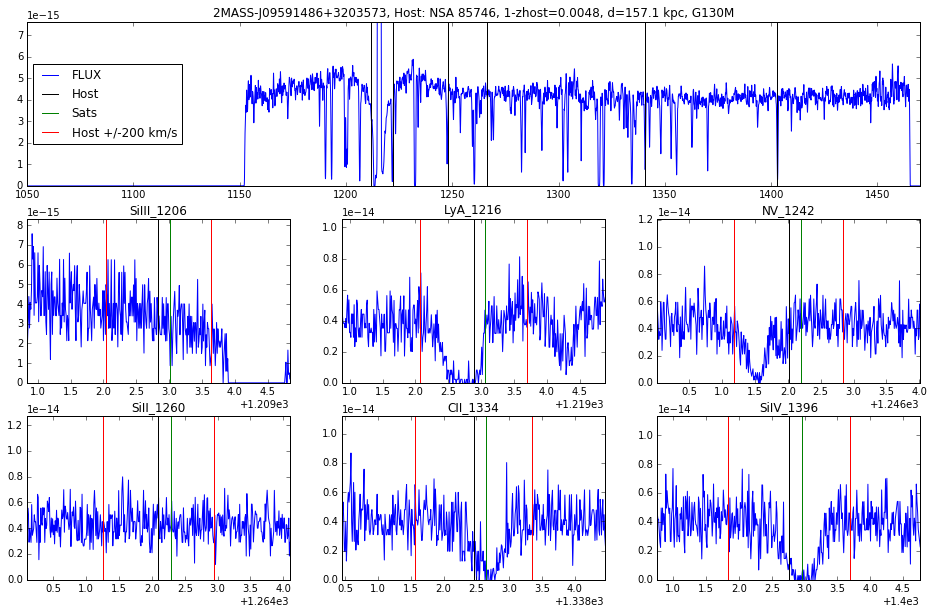

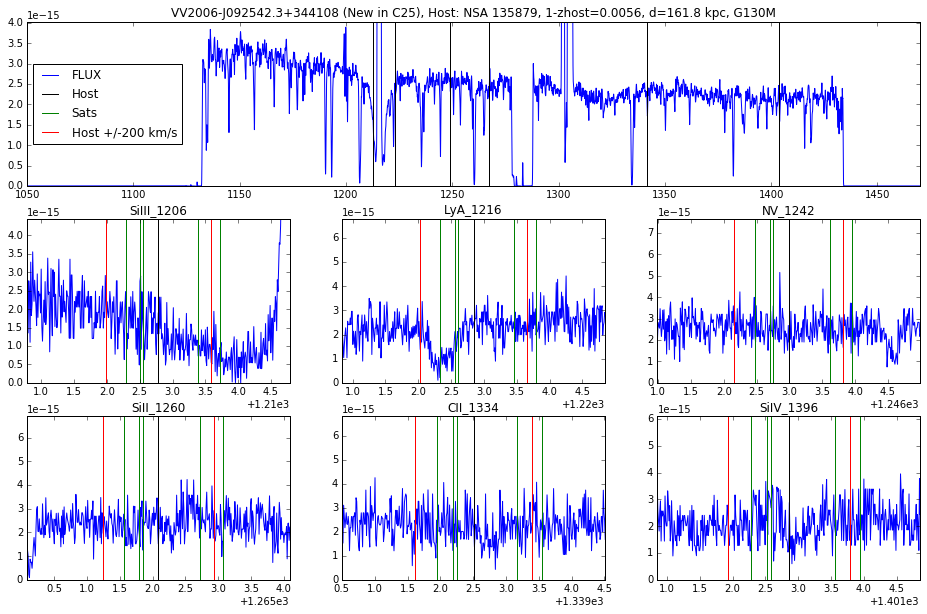

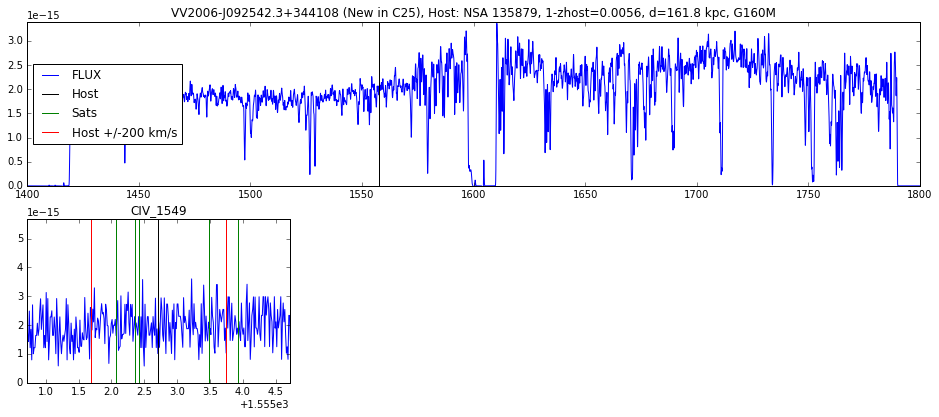

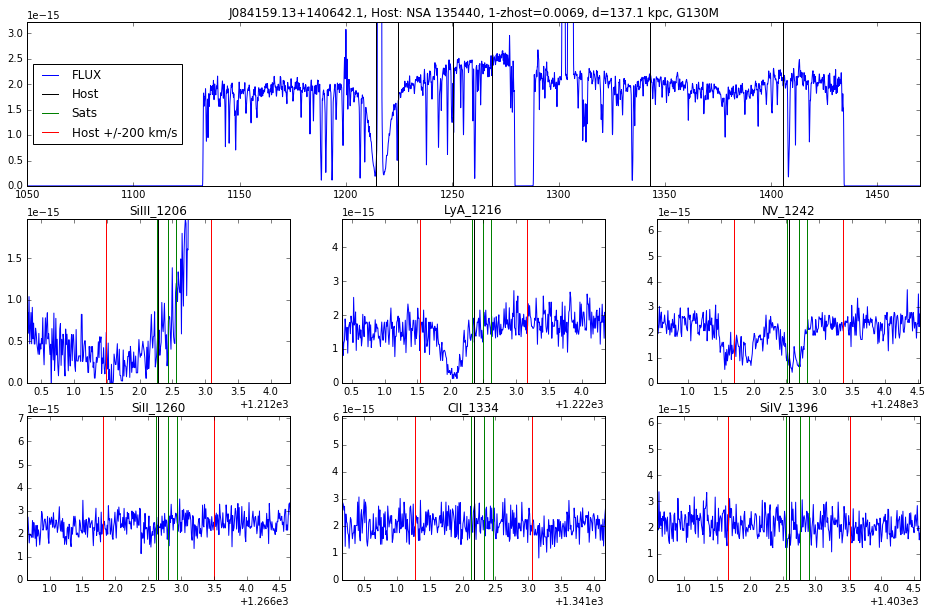

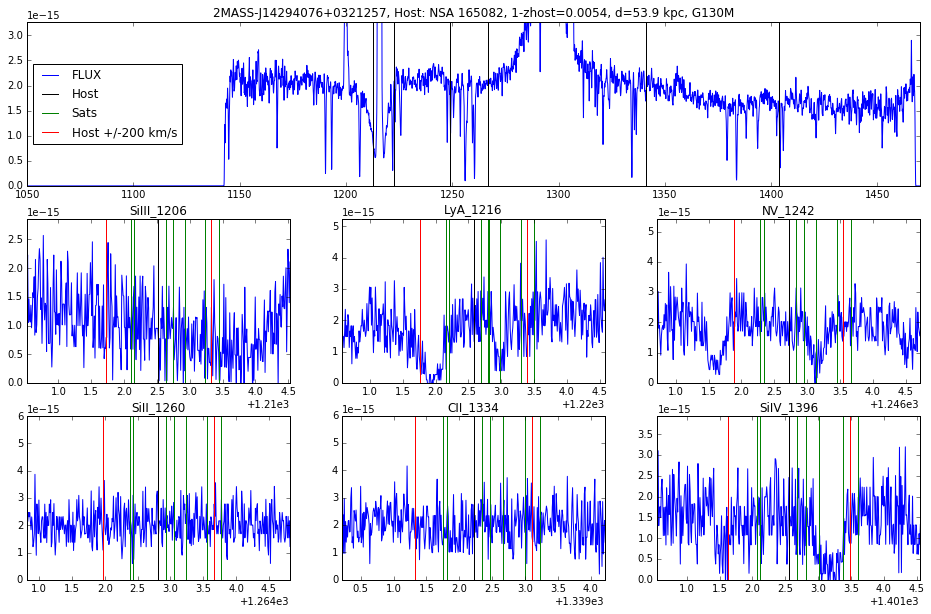

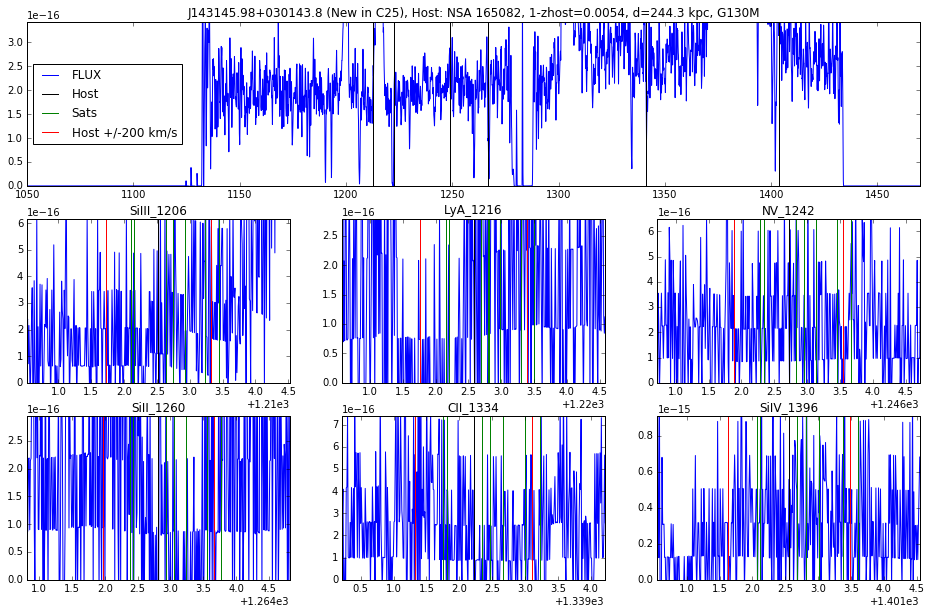

In [108]:
lines130 = ['SiIII_1206', 'LyA_1216', 'NV_1242', 'SiII_1260', 'CII_1334', 'SiIV_1396']
lines160 = ['CIV_1549']

smoothing = None #convolution.Box1DKernel(2.5)
smoothing1 = convolution.Gaussian1DKernel(10)

for row, spec_table130, spec_table160 in zip(hsla_to_check_tab, spec_tables, spec_tables160):
    for spec_table  in (spec_table130, spec_table160 ):
        if spec_table is None:
            continue
            
        is160 = np.mean(spec_table['WAVE'])>1500
        lines = lines160 if is160 else lines130
            
        hostrow = tab_hosts[tab_hosts['NSAID']==row['SAGA_NSAID']][0]
        zhost = (hostrow['vhelio']*u.km/u.s/cnst.c).decompose()

        impact_p = hostrow['skycoord'].separation(row['skycoord']).radian*hostrow['distance']*1000*u.kpc

        sats = tab_sats[tab_sats['HOST_NSAID']==hostrow['NSAID']]
        zsats = sats['SPEC_Z']

        wl = spec_table['WAVE']
        if smoothing is None:
            fx = spec_table['FLUX']
        else:
            fx = convolution.convolve(spec_table['FLUX'], smoothing)

        plt.figure()

        ax1 = plt.subplot2grid((3,3), (0,0), colspan=3)
        if smoothing1 is None:
            fx1 = spec_table['FLUX']
        else:
            fx1 = convolution.convolve(spec_table['FLUX'], smoothing1)

        ax1.plot(wl, fx1)
        msg = '{0[Target Name]}{4}, Host: NSA {1[NSAID]}, 1-zhost={2:.2}, d={3:.1f}, {5}'
        ax1.set_title(msg.format(row, hostrow, zhost, impact_p, 
                                 ' (New in C25)' if row['new_in_25'] else '',
                                 'G160M' if is160 else 'G130M'))
        if is160:
            ax1.set_xlim(1400, 1800)
        else:
            ax1.set_xlim(1050, 1470)
        ax1.set_ylim(0, np.median(fx1)*2)

        for i, line in enumerate(lines):
            linenm, linewl = line.split('_')
            linewl = float(linewl)

            plt.subplot(3, 3, i+4)
            plt.plot(wl, fx)
            plt.title(line)

            zhostwl = (1+zhost)*linewl
            wlrng = (zhostwl-2, zhostwl+2)
            plt.xlim(*wlrng)

            ax1.axvline(zhostwl, color='k')
            plt.axvline(zhostwl, color='k', label='Host')

            satlab = 'Sats'
            for zsat in zsats:
                plt.axvline((1+zsat)*linewl, c='g', label=satlab)
                satlab=None


            plt.axvline(zhostwl*(1+zhost+200*u.km/u.s/cnst.c)/(1+zhost), color='r', label='Host +/-200 km/s')
            plt.axvline(zhostwl*(1+zhost-200*u.km/u.s/cnst.c)/(1+zhost), color='r')
            plt.ylim(0, np.median(fx[(wlrng[0]<wl)&(wl<wlrng[1])])*3)


        handles, labels = plt.gca().get_legend_handles_labels()
        ax1.legend(handles, labels, loc='center left')

# Proposal plots

In [ ]:
hostcolor = '#C23B22'
satcolor = '#779ECB'

## Bullseye plot

In [ ]:
# first collect all the data

sample = qso_selection['sample_custom']
#sample = slice(None)

host_dists = []
sat_dists = []
host_pas = []
host_grpnums = []

sat_pas = []
sat_dzs = []
sat_grpnums = []

hosttonum = {'nothing':0}
for qso in qso_selection[sample]:
    
    host = tab_hosts[tab_hosts['NSAID']==qso['SAGA_NSAID']]
    sats = tab_sats[tab_sats['HOST_NSAID']==qso['SAGA_NSAID']]
    dist = host['distance'][0]*u.Mpc
    
    if host['NSAID'][0] in hosttonum:
        hostnum = hosttonum[host['NSAID'][0]]
    else:
        hostnum = np.max(hosttonum.values())+1
        hosttonum[host['NSAID'][0]] = hostnum
    
    host_dists.append(qso['skycoord'].separation(host[0]['skycoord']).radian*dist)
    host_pas.append(qso['skycoord'].position_angle(host[0]['skycoord']))
    host_grpnums.append(hostnum)
    
    sat_dists.extend(qso['skycoord'].separation(sats['skycoord']).radian*dist)
    sat_pas.extend(qso['skycoord'].position_angle(sats['skycoord']))
    hostz = (host['vhelio']/cnst.c.to(u.km/u.s).value)
    sat_dzs.extend(sats['SPEC_Z']-hostz)
    sat_grpnums.extend([hostnum]*len(sats))
    
    print(len(sats), qso['SAGA_name'], qso['SAGA_NSAID'])
del hosttonum['nothing']
    
for nm in 'host_dists,sat_dists,host_pas,sat_pas'.split(','):
    globals()[nm] = u.Quantity(globals()[nm])

In [ ]:
qso_selection[sample].show_in_notebook()

In [ ]:
ax.grid?

In [ ]:
ax = plt.subplot(projection='polar')

ax.plot(np.linspace(0, 2*np.pi,100), [300]*100, c=hostcolor)

hostx = host_pas.to(u.radian).value
hosty = host_dists.to(u.kpc).value
ax.scatter(hostx, hosty, 
           c=hostcolor, s=280, label='Hosts', lw=0, marker='s')
satx = sat_pas.to(u.radian).value
saty = sat_dists.to(u.kpc).value
ax.scatter(satx, saty, 
           c=satcolor, marker='o', s=360, label='Satellites', lw=0)
ax.scatter([0], [0], marker='*', s=200, color='k', label='QSO')

for x, y, num in zip(hostx, hosty, host_grpnums):
    plt.text(x, y, str(num), ha='center', va='center',fontsize=18, color='w')

for x, y, num in zip(satx, saty, sat_grpnums):
    plt.text(x, y, str(num), ha='center', va='center',fontsize=18, color='w')

ax.grid(True)

ax.spines['polar'].set_visible(False)
ax.set_xticks([])
ax.set_ylim(0,520)
ax.legend(loc=0, scatterpoints=2, fontsize=24)

ax.set_yticks([50, 100, 200, 300, 500])
ax.set_yticklabels([u'50', u'100', u'200',u'300' ,u'500 kpc'], fontsize=20)

plt.tight_layout()

plt.savefig('/Users/erik/Documents/obsproposals/HST24-SAGACOS/scijust/bullseye.pdf')

## Or a version that is more like d-v

In [ ]:
plt.scatter(sat_dists.to(u.kpc).value, sat_dzs*cnst.c.to(u.km/u.s), c=satcolor)
plt.scatter(host_dists.to(u.kpc).value, [0]*len(host_dists), c=hostcolor)
plt.ylim(-250,250)

In [ ]:
ax.scatter(host_pas.to(u.radian).value, host_dists.to(u.kpc).value, 
            c=hostcolor, s=180, label='Hosts', lw=0, marker='s')
ax.scatter(sat_pas.to(u.radian).value, sat_dists.to(u.kpc).value, 
            c=satcolor, marker='o', s=120, label='Satellites', lw=0)
ax.scatter([0], [0], marker='*', s=200, color='k', label='QSO')

ax.grid(True)

ax.spines['polar'].set_visible(False)
ax.set_xticks([])
ax.set_ylim(0,520)
ax.legend(loc=0, scatterpoints=2, fontsize=24)

ax.set_yticks([50, 100, 200, 300, 500])
ax.set_yticklabels([u'50', u'100', u'200',u'300' ,u'500 kpc'], fontsize=20)

plt.tight_layout()

plt.savefig('/Users/erik/Documents/obsproposals/HST24-SAGACOS/scijust/bullseye.pdf')

# "Horn" plot a la Tuminson+ 13

In [ ]:
#JT's data table for COS-Halos
with open('catalogs/cos_halos_catalog.tab') as f:
    cos_halos_tab_str = f.read()
    
inflags = False
for l in cos_halos_tab_str.split('\n'):
    if '# meaning of flags' in l:
        inflags = True
    if inflags:
        print(l)
    if l.replace('#', '').strip()=='':
        inflags = False
        
cos_halos_tab = table.Table.read(cos_halos_tab_str, format='ascii.commented_header', guess=False,header_start=19)
cos_halos_tab_good = cos_halos_tab[cos_halos_tab['flags']==0]

print(len(cos_halos_tab))
cos_halos_tab[:5].show_in_notebook()

In [ ]:
def abundance_matching_mh_to_ms(mh, z=0):
    #based on Moster+ 13 esp. Table 1
    M10 = 11.59
    M11 = 1.195
    N10 = 0.0351
    N11 = -0.0247
    beta10 = 1.376
    beta11 = -0.826
    gamma10 = 0.608
    gamma11 = 0.329
    
    oneminusa = z/(z+1)
    M1 = 10**(M10 + M11*oneminusa)
    N = N10 + N11*oneminusa
    beta = beta10 + beta11*oneminusa
    gamma = gamma10 + gamma11*oneminusa
    
    x = mh/M1
    
    msomh =  2*N/(x**-beta+x**gamma)
    return msomh*mh
    
lastres = None
def abundance_matching_ms_to_mh_scalar(ms, z=0):
    global lastres
    from scipy import optimize
    
    ofun = lambda mh: (abundance_matching_mh_to_ms(mh, z)-ms)**2
    
    res = optimize.minimize_scalar(ofun, (1,ms,1e18))
    lastres = res
    return res['x']
abundance_matching_ms_to_mh = np.vectorize(abundance_matching_ms_to_mh_scalar, excluded=set('z'))

In [ ]:
sample = qso_selection['sample_custom']
#sample = slice(None)


host_lms = []
satlabstr = 'This Proposal\'s Satellites'
satxys = []
satxs = []
satys = []
for qso in qso_selection[sample]: 
    host = tab_hosts[tab_hosts['NSAID']==qso['SAGA_NSAID']]
    sats = tab_sats[tab_sats['HOST_NSAID']==qso['SAGA_NSAID']]
    dist = host['distance'][0]*u.Mpc
    
    lsm = np.log10(host['stellar_mass'][0])
    
    host_lms.append(lsm)
    host_vs.append(0)
    
    dv = (sats['SPEC_Z']*cnst.c - host['vhelio']*u.km/u.s).to(u.km/u.s)
    dvspan = np.append(dv.value, 0)
    
    satxs.extend([lsm]*len(sats))
    satys.extend(dv.value)
    satxys.append((satxs[-1], satys[-1]))
    
    width = .015
    height = np.ptp(dvspan)
    lowerx = lsm-width/2
    lowery = np.min(dvspan)
    plt.gca().add_patch(plt.Rectangle((lowerx, lowery), width, height, color=satcolor, alpha=.8, label=satlabstr, zorder=1))
    
    #plt.plot(satxys[-1][0], satxys[-1][1], '-o', c=satcolor, mec=satcolor, mew=0, label=satlabstr, ms=12)
    satlabstr = None
    
plt.scatter(satxs, satys, color=satcolor, lw=0, s=155)
    
#plt.scatter(host_lms, [0]*len(host_lms), c=hostcolor, marker='s', s=200, lw=0, label='This proposal\'s hosts')
plt.axhline(0, c=hostcolor, lw=2, zorder=0)

plt.scatter(cos_halos_tab_good['mstar'], cos_halos_tab_good['v'], 
            color='k', label='COS-Halos Absorbers', marker='^', s=180,zorder=2)

#lmsmin, lmsmax = plt.xlim(9.5,11.2)
lmsmin, lmsmax = plt.xlim(9.75,10.65)

msrng = np.logspace(lmsmin, 11.5, 25)
mhrng = abundance_matching_ms_to_mh(msrng)

resc = 150*u.kpc
vesc = ((2*cnst.G*(mhrng/2)*u.Msun/(resc))**0.5).to(u.km/u.s)
#plt.plot(np.log10(msrng), vesc,c='k', ls=':', label=r'$v_{\rm esc}$')
#plt.plot(np.log10(msrng), -vesc,c='k', ls=':')

plt.ylim(-250,250)

plt.xlabel(r'$\log(M_*/M_\odot) {\rm \; of \; Host}$', fontsize=32)
plt.ylabel(r'$\Delta v \; [{\rm km \; s^{-1}}]$', fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

h, l = plt.gca().get_legend_handles_labels()
#h.append(h.pop(1))
#l.append(l.pop(1))
plt.legend(h, l, loc='lower left', scatterpoints=2, fontsize=24)

plt.twiny()
plt.xlim(np.log10(mhrng[0]), np.log10(mhrng[-1]))
plt.xticks(fontsize=20)
plt.xlabel(r'$\log(M_{\rm halo}/M_\odot) {\rm \; of \; Host}$', fontsize=32)

plt.tight_layout()
plt.savefig('/Users/erik/Documents/obsproposals/HST24-SAGACOS/scijust/horn.pdf')

In [ ]:
chms = cos_halos_tab_good['mstar'].view(np.ndarray)
chdvs = cos_halos_tab_good['v'].view(np.ndarray)
chdvsub = chdvs[(10<chms)&(chms<10.6)&(-300<chdvs)&(chdvs<300)]

satms = []
satdvs = []
for ms, dv in satxys:
    satms.extend(ms)
    satdvs.extend(dv)
satms = u.Quantity(satms).value
satdvs = u.Quantity(satdvs).value
satdvsub = satdvs[(10<satms)&(satms<10.6)]

ahist(chdvsub, bins=10, histtype='step')
ahist(satdvsub, bins=10, histtype='step')

stats.ks_2samp(chdvsub, satdvsub)

# r vs FUV_MAG for context 

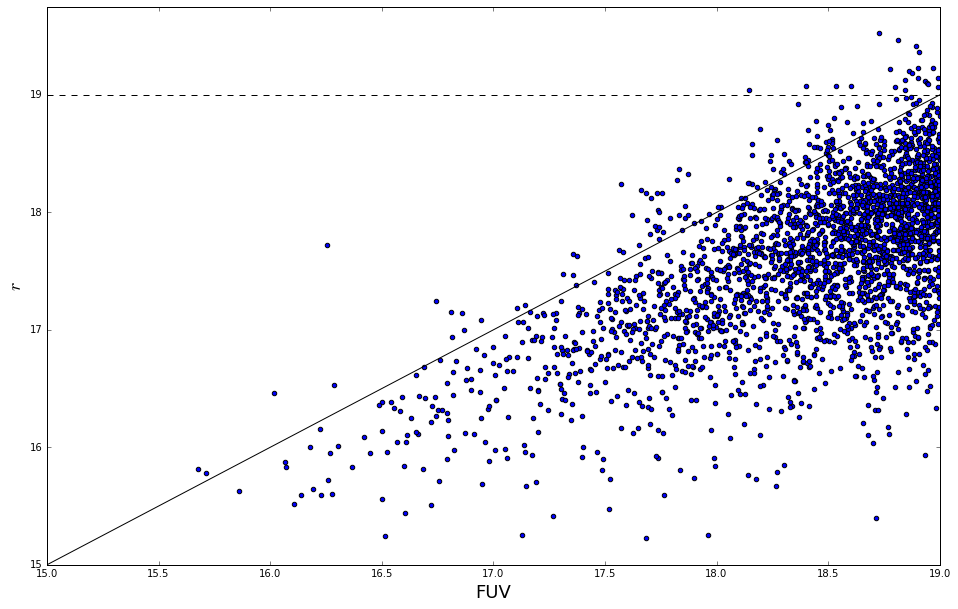

In [39]:
plt.scatter(tab_qso19['FUV_MAG'],tab_qso19['PSFMAG_R'])
plt.xlabel('FUV', fontsize=18)
plt.ylabel('$r$', fontsize=18)
plt.plot([15,19], [15,19], c='k')

plt.xlim(15,19.)
plt.ylim(15,19.75)

plt.axhline(19, c='k', ls='--')

plt.savefig('/Users/erik/Dropbox/rvsFUV.pdf')